In [1]:
import sys
import pandas as pd
import copy
import numpy as np
import matplotlib as mpl
import matplotlib.dates as dates
import matplotlib.pyplot as plt
import datetime
import itertools
sys.path.append("C:/dev/pyktrader3/")
from pycmqlib3.utility import misc
from bktest import backtest
import pycmqlib3.analytics.data_handler as dh

In [24]:
ferrous_products_mkts = ['rb', 'hc', 'i', 'j', 'jm']
ferrous_mixed_mkts = ['ru', 'FG', 'ZC', 'SM', "SF"]
base_metal_mkts = ['cu', 'al', 'zn', 'pb', 'ni', 'sn']
precious_metal_mkts = ['au', 'ag']
ind_metal_mkts = ferrous_products_mkts + ferrous_mixed_mkts + base_metal_mkts  
petro_chem_mkts = ['l', 'pp', 'v', 'TA', 'MA', 'bu', 'sc', 'fu', 'eg']
ind_all_mkts = ind_metal_mkts + petro_chem_mkts
ags_oil_mkts = ['m', 'RM', 'y', 'p', 'OI', 'a', 'c', 'cs'] #, 'b']
ags_soft_mkts = ['CF', 'SR', 'jd', 'AP'] #, 'sp', 'CJ', 'UR']
ags_all_mkts = ags_oil_mkts + ags_soft_mkts
eq_fut_mkts = ['IF', 'IH', 'IC']
bond_fut_mkts = ['T', 'TF']
fin_all_mkts = eq_fut_mkts + bond_fut_mkts
commod_all_mkts = ind_all_mkts + ags_all_mkts + precious_metal_mkts
all_markets = commod_all_mkts + fin_all_mkts
daily_start_dict = { 'c': datetime.date(2011,1,1), 'm': datetime.date(2011,1,1),
    'y': datetime.date(2011,1,1), 'l': datetime.date(2011,1,1), 'rb':datetime.date(2011,1,1),
    'p': datetime.date(2011,1,1), 'cu':datetime.date(2011,1,1), 'al':datetime.date(2011,1,1),
    'zn':datetime.date(2011,1,1), 'au':datetime.date(2011,1,1), 'v': datetime.date(2011,1,1),
    'a': datetime.date(2011,1,1), 'ru':datetime.date(2011,1,1), 'ag':datetime.date(2012,6,1),
    'i': datetime.date(2014,1,1), 'j': datetime.date(2012,6,1), 'jm':datetime.date(2013,7,1),
    'CF':datetime.date(2012,5,1),  'TA':datetime.date(2012,4,15),
    'PM':datetime.date(2013,10,1), 'RM':datetime.date(2013,1,1),  'SR':datetime.date(2013,1,1),
    'FG':datetime.date(2013,1,1),  'OI':datetime.date(2013,5,1),  'RI':datetime.date(2013,1,1),
    'WH':datetime.date(2014,5,1),  'pp':datetime.date(2014,5,1),
    'IF':datetime.date(2010,5,1),  'MA':datetime.date(2012,1,1),  'TF':datetime.date(2014,6,1),
    'IH':datetime.date(2015,5,1),  'IC':datetime.date(2015,5,1),  'cs':datetime.date(2015,2,1),
    'jd':datetime.date(2014,5,1),  'ni':datetime.date(2015,5,1),  'sn':datetime.date(2017,4,1),
    'ZC':datetime.date(2013,11,1), 'hc':datetime.date(2016, 4, 1), 'SM': datetime.date(2017,1,1),
    'SF': datetime.date(2017,9,1), 'CY': datetime.date(2017, 9, 1), 'AP': datetime.date(2018, 1, 1),
    'TS': datetime.date(2018, 9, 1), 'fu': datetime.date(2018, 9, 1), 'sc': datetime.date(2018, 8, 1),
    'b': datetime.date(2018, 1, 1), 'pb': datetime.date(2016, 7, 1), 'bu': datetime.date(2015,9,15),
    'T':datetime.date(2015,6,1), 'ss': datetime.date(2020, 5, 1), 'sp': datetime.date(2019, 5, 1),
    'CJ': datetime.date(2019, 8, 9), 'UR': datetime.date(2019, 8, 9), 'SA': datetime.date(2020, 1, 1),
    'eb': datetime.date(2020, 1, 1), 'eg': datetime.date(2019, 5, 1), 'rr': datetime.date(2019, 9, 1),
    'pg': datetime.date(2020, 9, 1), 'lu': datetime.date(2020, 8, 1),}
min_start_dict = { 'c': datetime.date(2011,1,1), 'm': datetime.date(2011,1,1),
    'y': datetime.date(2011,1,1), 'l': datetime.date(2011,1,1), 'rb':datetime.date(2011,1,1),
    'p': datetime.date(2011,1,1), 'cu':datetime.date(2011,1,1), 'al':datetime.date(2011,1,1),
    'zn':datetime.date(2011,1,1), 'au':datetime.date(2011,1,1), 'v': datetime.date(2011,1,1),
    'a': datetime.date(2011,1,1), 'ru':datetime.date(2011,1,1), 'ag':datetime.date(2012,6,1),
    'i': datetime.date(2014,1,1), 'j': datetime.date(2012,6,1), 'jm':datetime.date(2013,7,1),
    'CF':datetime.date(2012,5,1),  'TA':datetime.date(2012,4,15),
    'PM':datetime.date(2013,10,1), 'RM':datetime.date(2013,1,1),  'SR':datetime.date(2013,1,1),
    'FG':datetime.date(2013,1,1),  'OI':datetime.date(2013,5,1),  'RI':datetime.date(2013,1,1),
    'WH':datetime.date(2014,5,1),  'pp':datetime.date(2014,5,1),
    'IF':datetime.date(2010,5,1),  'MA':datetime.date(2012,1,1),  'TF':datetime.date(2014,6,1),
    'IH':datetime.date(2015,5,1),  'IC':datetime.date(2015,5,1),  'cs':datetime.date(2015,2,1),
    'jd':datetime.date(2014,5,1),  'ni':datetime.date(2015,5,1),  'sn':datetime.date(2017,4,1),
    'ZC':datetime.date(2013,11,1), 'hc':datetime.date(2016, 4, 1), 'SM': datetime.date(2017,1,1),
    'SF': datetime.date(2017,9,1), 'CY': datetime.date(2017, 9, 1), 'AP': datetime.date(2018, 1, 1),
    'TS': datetime.date(2018, 9, 1), 'fu': datetime.date(2018, 9, 1), 'sc': datetime.date(2018, 8, 1),
    'b': datetime.date(2018, 1, 1), 'pb': datetime.date(2016, 7, 1), 'bu': datetime.date(2015,9,15),
    'T':datetime.date(2015,6,1), 'ss': datetime.date(2020, 5, 1), 'sp': datetime.date(2019, 5, 1),
    'CJ': datetime.date(2019, 8, 9), 'UR': datetime.date(2019, 8, 9), 'SA': datetime.date(2020, 1, 1),
    'eb': datetime.date(2020, 1, 1), 'eg': datetime.date(2019, 5, 1), 'rr': datetime.date(2019, 9, 1),
    'pg': datetime.date(2020, 9, 1), 'lu': datetime.date(2020, 8, 1),}

In [27]:
field_list = ['open', 'high', 'low', 'close', 'volume', 'openInterest', 'contract', 'shift']
factor_list = ['lrstd','upstd','lrskew','lrkurt','mincnt','volmf','oimf','trdstr','volmfratio']
shared_cols = ['date', 'split_idx']
start_date = datetime.date(2010, 1, 1)
end_date = datetime.date(2021, 6, 4)
pnl_tenors = ['1y', '2y', '3y', '4y', '5y', '6y', '8y']

delimiter = '-'
atr_win = 20
file_folder = "C:\\dev\\data\\data_cache\\"

sim_products = ['CJ', 'UR', 'SA', 'sp', 'eg', 'eb', 'T'] #ind_all_mkts + ags_all_mkts
shift_mode = 1
freq = 'd'


if freq == 'd':
    sim_start_dict = daily_start_dict
else:
    sim_start_dict = min_start_dict
    
dbtbl_prefix = ''
args = {'roll_rule': '-30b', 'freq': freq, 'shift_mode': shift_mode, 'dbtbl_prefix': dbtbl_prefix}
ferrous_products_args = args
ferro_mixed_mkt_args = args
base_args = {'roll_rule': '-30b', 'freq': freq, 'shift_mode': shift_mode, 'dbtbl_prefix': dbtbl_prefix}
base2_args = {'roll_rule': '-40b', 'freq': freq, 'shift_mode': shift_mode, 'dbtbl_prefix': dbtbl_prefix}
v_args  = {'roll_rule': '-28b', 'freq': freq, 'shift_mode': shift_mode, 'dbtbl_prefix': dbtbl_prefix}
sc_args = {'roll_rule': '-20b', 'freq': freq, 'shift_mode': shift_mode, 'dbtbl_prefix': dbtbl_prefix}
eq_args = {'roll_rule': '-1b', 'freq': freq, 'shift_mode': shift_mode, 'dbtbl_prefix': dbtbl_prefix}
bond_args = {'roll_rule': '-30b', 'freq': freq, 'shift_mode': shift_mode, 'dbtbl_prefix': dbtbl_prefix}
precious_args = {'roll_rule': '-12b', 'freq': freq, 'shift_mode': shift_mode, 'dbtbl_prefix': dbtbl_prefix}

df_list = []

for idx, asset in enumerate(sim_products):
    use_args = copy.copy(args)
    if asset in eq_fut_mkts:
        use_args = eq_args
    elif asset in ['cu', 'al', 'zn', 'pb', 'sn']:
        use_args = base_args
    elif asset in ['ni']:
        use_args = base2_args
    elif asset in ['sc']:
        use_args = sc_args
    elif asset in ['v']:
        use_args = v_args
    elif asset in bond_fut_mkts:
        use_args = bond_args
    elif asset in precious_metal_mkts:
        use_args = precious_args
    use_args['start_date'] = max(sim_start_dict.get(asset, start_date), start_date)
    use_args['end_date'] = end_date        
    for idy, nb in enumerate([1, 2]):
        if freq == 'd':
            use_args['n'] = nb
            print("loading mkt = %s, nb = %s, args = %s" % (asset, nb, use_args))
            df = misc.nearby(asset, **use_args)
            xdf = df[field_list]
        else:
            filename = "%s_%s_%s_%s.csv" % (asset, nb, freq, end_date.strftime("%Y%m%d"))
            df = pd.read_csv(file_folder + filename, index_col=0)
            df['date'] = df['date'].apply(lambda x: datetime.datetime.strptime(x, "%Y-%m-%d %H:%M:%S"))            
            df['datetime'] = df['datetime'].apply(lambda x: datetime.datetime.strptime(x, "%Y-%m-%d %H:%M:%S"))
            df = df.drop_duplicates(subset=['date', 'split_idx'], keep='last').set_index(['date', 'split_idx'])
            df = df.drop(['cum_idx'], axis=1)
            ep_field = [ col for col in df.columns if 'exec_price' in col]
            xdf = df[field_list + ep_field + factor_list]
            #xdf['expiry'] = xdf['contract'].apply(lambda x: misc.contract_expiry(x, misc.CHN_Holidays))
        xdf['contmth'] = xdf['contract'].apply(lambda x: misc.inst2contmth(x))
        xdf['mth'] = xdf['contmth'].apply(lambda x: x//100 * 12 + x % 100)        
        xdf.columns = [delimiter.join((asset+str(nb), col)) for col in xdf.columns]
        df_list.append(xdf)

df = pd.concat(df_list, axis = 1, sort = False).sort_index()
if freq == 'd':
    df.index.name = 'date'
df = df.reset_index()
if freq != 'd':
    df['date'] = df['date'].dt.date
print(df.tail(20))


loading mkt = CJ, nb = 1, args = {'roll_rule': '-30b', 'freq': 'd', 'shift_mode': 1, 'dbtbl_prefix': '', 'start_date': datetime.date(2019, 8, 9), 'end_date': datetime.date(2021, 6, 4), 'n': 1}
loading mkt = CJ, nb = 2, args = {'roll_rule': '-30b', 'freq': 'd', 'shift_mode': 1, 'dbtbl_prefix': '', 'start_date': datetime.date(2019, 8, 9), 'end_date': datetime.date(2021, 6, 4), 'n': 2}
loading mkt = UR, nb = 1, args = {'roll_rule': '-30b', 'freq': 'd', 'shift_mode': 1, 'dbtbl_prefix': '', 'start_date': datetime.date(2019, 8, 9), 'end_date': datetime.date(2021, 6, 4), 'n': 1}
loading mkt = UR, nb = 2, args = {'roll_rule': '-30b', 'freq': 'd', 'shift_mode': 1, 'dbtbl_prefix': '', 'start_date': datetime.date(2019, 8, 9), 'end_date': datetime.date(2021, 6, 4), 'n': 2}
loading mkt = SA, nb = 1, args = {'roll_rule': '-30b', 'freq': 'd', 'shift_mode': 1, 'dbtbl_prefix': '', 'start_date': datetime.date(2020, 1, 1), 'end_date': datetime.date(2021, 6, 4), 'n': 1}
loading mkt = SA, nb = 2, args = {'

IndexError: index -1 is out of bounds for axis 0 with size 0

In [7]:
def run_ts_test(input_args):
    product_list = input_args['product_list']
    mod_prod_list = [asset + str(1) for asset in product_list]
    win = input_args['win']
    ma_win = input_args['ma_win']
    vol_win = input_args['std_win']
    pos_std = input_args['pos_std']
    rebal_freq = input_args['rebal_freq']
    cost_ratio = input_args.get('cost_ratio', 0.5)
    run_mode = input_args.get('run_mode', "ryield")
    params = input_args.get('params', [0.0, 0.0])
    prefix = input_args.get('prefix', "")
    run_name = input_args.get('run_name', 'test')
    start_date = input_args.get('start_date', None)
    end_date = input_args.get('end_date', None)
    total_risk = input_args.get('total_risk', 5000000.0)
    exec_field = input_args.get('exec_field', 'open')
    select_cols = []
    data_field = ''
    pos_func, pos_args, _ = input_args.get('pos_map', (None, {}, ''))
    
    for col in df.columns:
        if col in shared_cols:
            select_cols.append(col)
        else:
            col_split = col.split(delimiter)
            if col_split[0][:-1] in product_list:
                select_cols.append(col)

    xdf= df[select_cols].copy(deep = True)
    if start_date:
        xdf = xdf[xdf['date']>= start_date]
    if end_date:
        xdf = xdf[xdf['date']<= end_date]
    for asset in product_list:
        if shift_mode == 1:
            xdf[delimiter.join((asset + str(1), 'ryield'))] = \
                    (np.log(xdf[delimiter.join((asset + str(1), 'close'))] - xdf[delimiter.join((asset + str(1), 'shift'))]) \
                    - np.log(xdf[delimiter.join((asset + str(2), 'close'))]- xdf[delimiter.join((asset + str(2), 'shift'))]))\
                    /(xdf[delimiter.join((asset + str(2), 'mth'))] - xdf[delimiter.join((asset + str(1), 'mth'))]) * 12.0
            orig_close = xdf[delimiter.join((asset+ str(1), 'close'))]-xdf[delimiter.join((asset+ str(1), 'shift'))]
            for i in [1, 2]:
                xdf[delimiter.join((asset + str(i), 'lr'))] = \
                    np.log(xdf[delimiter.join((asset + str(i), 'close'))]-xdf[delimiter.join((asset + str(i), 'shift'))]) \
                    - np.log(xdf[delimiter.join((asset + str(i), 'close'))].shift(1)-xdf[delimiter.join((asset + str(i), 'shift'))])
        elif shift_mode == 2:
            xdf[delimiter.join((asset + str(1), 'ryield'))] = \
                    (np.log(xdf[delimiter.join((asset + str(1), 'close'))]) - np.log(xdf[delimiter.join((asset + str(2), 'close'))])\
                     - xdf[delimiter.join((asset + str(1), 'shift'))] + xdf[delimiter.join((asset + str(2), 'shift'))]) \
                    /(xdf[delimiter.join((asset + str(2), 'mth'))] - xdf[delimiter.join((asset + str(1), 'mth'))]) * 12.0
            orig_close = xdf[delimiter.join((asset+ str(1), 'close'))]* np.exp(-xdf[delimiter.join((asset+ str(1), 'shift'))])
            for i in [1, 2]:
                xdf[delimiter.join((asset + str(i), 'lr'))] = \
                    np.log(xdf[delimiter.join((asset + str(i), 'close'))])- np.log(xdf[delimiter.join((asset + str(i), 'close'))].shift(1))
        else:
            xdf[delimiter.join((asset + str(1), 'ryield'))] = \
                    (np.log(xdf[delimiter.join((asset + str(1), 'close'))]) - np.log(xdf[delimiter.join((asset + str(2), 'close'))])) \
                    /(xdf[delimiter.join((asset + str(2), 'mth'))] - xdf[delimiter.join((asset + str(1), 'mth'))]) * 12.0
            orig_close = df[delimiter.join((asset+ str(1), 'close'))]
            for i in [1, 2]:
                xdf[delimiter.join((asset + str(i), 'lr'))] = \
                    np.log(xdf[delimiter.join((asset + str(i), 'close'))])- np.log(xdf[delimiter.join((asset + str(i), 'close'))].shift(1))
        xdf[delimiter.join((asset + str(1), 'basmom'))] = xdf[delimiter.join((asset + str(1), 'lr'))].rolling(win).sum() \
                                                        - xdf[delimiter.join((asset + str(2), 'lr'))].rolling(win).sum()
        xdf[delimiter.join((asset + str(1), 'mom'))] = xdf[delimiter.join((asset + str(1), 'lr'))].rolling(win).sum()
        xdf[delimiter.join((asset + str(1), 'upratio'))] = xdf[delimiter.join((asset + str(1), 'lr'))].rolling(win).agg(lambda x: (x>0).sum()/win) - 0.5 
        
        for field in reverse_list:
            if field in run_mode:
                if delimiter.join((asset + str(1), field)) in xdf.columns:
                    xdf[delimiter.join((asset + str(1), field))] = - xdf[delimiter.join((asset + str(1), field))]
                else:
                    print("Field=%s is not in dataframe." % field)
                break            
                
        if 'rsi' in run_mode:
            rsi_output = dh.RSI_F(xdf, win, prefix = asset + str(1) + delimiter)
            xdf[delimiter.join((asset + str(1), 'rsi'))] = rsi_output[asset + str(1) + delimiter + 'RSI' + str(win)]
        elif 'clbrk' in run_mode:
            chmax = xdf[delimiter.join((asset + str(1), 'close'))].rolling(win).max()
            chmin = xdf[delimiter.join((asset + str(1), 'close'))].rolling(win).min()
            chavg = (chmax + chmin)/2.0
            xdf[delimiter.join((asset + str(1), 'clbrk'))] = (xdf[delimiter.join((asset + str(1), 'close'))] - chavg)/(chmax - chmin)
        elif 'hlbrk' in run_mode:
            chmax = xdf[delimiter.join((asset + str(1), 'high'))].rolling(win).max()
            chmin = xdf[delimiter.join((asset + str(1), 'low'))].rolling(win).min()
            chavg = (chmax + chmin)/2.0
            xdf[delimiter.join((asset + str(1), 'hlbrk'))] = (xdf[delimiter.join((asset + str(1), 'close'))] - chavg)/(chmax - chmin)
        elif 'macd' in run_mode:
            xdf[delimiter.join((asset + str(1), 'ema1'))] = dh.EMA(xdf, win, field = 'close', prefix = asset + str(1) + delimiter)
            xdf[delimiter.join((asset + str(1), 'ema2'))] = dh.EMA(xdf, int(win * params[0]), field = 'close', prefix = asset + str(1) + delimiter)
            xdf[delimiter.join((asset + str(1), 'mstd'))] = dh.STDEV(xdf, int(win * params[1]), field = 'close', prefix = asset + str(1) + delimiter)
            xdf[delimiter.join((asset + str(1), 'macd'))] = (xdf[delimiter.join((asset + str(1), 'ema1'))] - xdf[delimiter.join((asset + str(1), 'ema2'))])/xdf[delimiter.join((asset + str(1), 'mstd'))]
        elif run_mode == 'mixmom':
            xdf[delimiter.join((asset + str(1), 'mixmom'))] = (xdf[delimiter.join((asset + str(1), 'mom'))] * xdf[delimiter.join((asset + str(1), 'upratio'))]).apply(lambda x: x if x>0 else 0) \
                                                              * xdf[delimiter.join((asset + str(1), 'mom'))].apply(lambda x: misc.sign(x)) 
        data_field = run_mode
        if pos_std == 0:
            xdf[delimiter.join((asset + str(1), 'std'))] = orig_close
        elif pos_std == 1:
            if shift_mode == 1:
                xdf[delimiter.join((asset + str(1), 'std'))] = dh.ATR(xdf, vol_win, prefix = asset + '1' + delimiter).fillna(method='bfill')
            elif shift_mode == 2:
                xdf[delimiter.join((asset + str(1), 'std'))] = (np.log(xdf[delimiter.join((asset + str(1), 'close'))]) \
                                - np.log(xdf[delimiter.join((asset + str(1), 'close'))].shift(1))).rolling(vol_win).std() \
                                * orig_close
            else:
                xdf[delimiter.join((asset + str(1), 'std'))] = orig_close
        if 'sma' == run_mode[-3:]:
            ref_field = run_mode[:-3]
            xdf[delimiter.join((asset + str(1), data_field))] = xdf[delimiter.join((asset + str(1), ref_field))].rolling(ma_win).mean()
        elif 'ema' == run_mode[-3:]:
            ref_field = run_mode[:-3]
            xdf[delimiter.join((asset + str(1), data_field))] = dh.EMA(xdf, ma_win, field = ref_field, prefix = asset + str(1) + delimiter)
        elif 'xma' == run_mode[-3:]:   
            ref_field = run_mode[:-3]
            xdf[delimiter.join((asset + str(1), data_field))] = xdf[delimiter.join((asset + str(1), ref_field))] \
                                                            - xdf[delimiter.join((asset + str(1), ref_field))].rolling(ma_win).mean()
        elif 'xea' == run_mode[-3:]:
            ref_field = run_mode[:-3]
            xdf[delimiter.join((asset + str(1), data_field))] = xdf[delimiter.join((asset + str(1), ref_field))] \
                                                            - dh.EMA(xdf, ma_win, field = ref_field, prefix = asset + str(1) + delimiter)
        elif 'nma' == run_mode[-3:]:
            ref_field = run_mode[:-3]
            xdf[delimiter.join((asset + str(1), data_field))] = xdf[delimiter.join((asset + str(1), ref_field))] \
                                                            / dh.STDEV(xdf, ma_win, field = ref_field, prefix = asset + str(1) + delimiter)
        elif 'nmb' == run_mode[-3:]:
            ref_field = run_mode[:-3]
            xdf[delimiter.join((asset + str(1), data_field))] = xdf[delimiter.join((asset + str(1), ref_field))] \
                                                            / dh.BSTDEV(xdf, ma_win, field = ref_field, prefix = asset + str(1) + delimiter)
        elif 'zlv' == run_mode[-3:]:
            ref_field = run_mode[:-3]
            xdf[delimiter.join((asset + str(1), data_field))] = (xdf[delimiter.join((asset + str(1), ref_field))] \
                                                                 - xdf[delimiter.join((asset + str(1), ref_field))].rolling(ma_win).mean()) \
                                                            / dh.STDEV(xdf, ma_win, field = ref_field, prefix = asset + str(1) + delimiter)
        if pos_func:
            xdf[delimiter.join((asset + str(1), data_field))] = xdf[delimiter.join((asset + str(1), data_field))].apply(lambda x: pos_func(x, **pos_args))

    select_cols = []
    for col in xdf.columns:
        if col in shared_cols:
            select_cols.append(col)
        else:
            col_split = col.split(delimiter)
            if (col_split[0] in mod_prod_list):
                select_cols.append(col)    
    
    adf = xdf[select_cols].copy()
    fdf = adf[[delimiter.join((asset, data_field)) for asset in mod_prod_list]]
    adf['prod_count'] = fdf.apply(lambda x: x.count() if x.count() > 0 else np.nan, axis=1)
    adf['rebal_seqno'] = range(len(adf.index))
    
    margin_rate = [0.08, 0.08]
    offset_list = [ backtest.trade_offset_dict.get(asset, 0.0) for asset in product_list]
    offset_list = [ offset * cost_ratio for offset in offset_list]
    start_capital = 0.0

    long_pos = pd.DataFrame(0, columns = mod_prod_list, index = adf.index)
    short_pos = pd.DataFrame(0, columns = mod_prod_list, index = adf.index)

    for rebal_idx in range(rebal_freq):
        long_tmp = pd.DataFrame(columns=mod_prod_list, index = adf.index)
        short_tmp = pd.DataFrame(columns=mod_prod_list, index = adf.index)
        rebal_flag = adf['rebal_seqno'].apply(lambda x: (x % rebal_freq) == rebal_idx)
        for asset in mod_prod_list:
            pflag = (adf[delimiter.join((asset, data_field))] >= 0) & rebal_flag
            nflag = (adf[delimiter.join((asset, data_field))] <= 0) & rebal_flag
            long_tmp.loc[pflag, asset] = adf.loc[pflag, delimiter.join((asset, data_field))]
            long_tmp.loc[nflag, asset] = 0.0
            short_tmp.loc[nflag, asset] = -adf.loc[nflag, delimiter.join((asset, data_field))]
            short_tmp.loc[pflag, asset] = 0.0 
        long_tmp = long_tmp.fillna(method='ffill').fillna(0)
        short_tmp = short_tmp.fillna(method='ffill').fillna(0)
        long_pos = long_pos + long_tmp/rebal_freq
        short_pos = short_pos + short_tmp/rebal_freq
    
    extract_fields = ['open', 'close', 'traded_price', 'contract', 'cost', 'pos']
    df_list = []
    dpnl_by_asset = []
    for asset, offset in zip(mod_prod_list, offset_list):
        long_pos[asset] = (long_pos[asset] * total_risk  \
                    /(adf[delimiter.join((asset,'std'))])).shift(1).fillna(method='ffill')
        short_pos[asset] = (short_pos[asset] * total_risk \
                    /(adf[delimiter.join((asset,'std'))])).shift(1).fillna(method='ffill')
        adf[delimiter.join((asset, 'pos'))] = long_pos[asset].fillna(0.0) - short_pos[asset].fillna(0.0)
        adf[delimiter.join((asset, 'traded_price'))] = adf[delimiter.join((asset, exec_field))]
        #adf[delimiter.join((asset, 'pos'))].iloc[-1] = 0
        adf[delimiter.join((asset, 'cost'))] = \
                abs(adf[delimiter.join((asset, 'pos'))] \
                - adf[delimiter.join((asset, 'pos'))].shift(1).fillna(0.0)) * offset
        adf[delimiter.join((asset, 'cost'))] = adf[delimiter.join((asset, 'cost'))].fillna(0.0)
        fields = [delimiter.join((asset, field)) for field in extract_fields] 
        tdf = adf[fields]
        tdf.columns = extract_fields
        if freq == 'm':
            tdf['date'] = adf['date']
            tdf['min_id'] = adf['min_id']
        elif 's' in freq:
            tdf['date'] = adf['date']
            tdf['split_idx'] = adf['split_idx']
        elif freq == 'd':
            tdf['date'] = adf['date']
        #closed_trades = backtest.simdf_to_trades1(tdf, slippage = offset)
        df_list.append(tdf)
        (res_pnl, ts) = backtest.get_pnl_stats([tdf], margin_rate, freq, tenors = pnl_tenors, start_capital = start_capital, cost_ratio = cost_ratio)
        dpnl_by_asset.append(ts['daily_pnl'])
    dpnl_df = pd.concat(dpnl_by_asset, join='outer', sort = False, axis=1)
    dpnl_df = dpnl_df.fillna(method='ffill').fillna(0.0)
    dpnl_df.columns = mod_prod_list
    (res_pnl, ts) = backtest.get_pnl_stats(df_list, margin_rate, freq, tenors = pnl_tenors, start_capital = start_capital, cost_ratio = cost_ratio)
    pos_df  = adf[[delimiter.join((asset, 'pos')) for asset in mod_prod_list]]
    pos_df.columns  = [delimiter.join((asset, 'pos')) for asset in product_list]
    cum_pnl = ts['cum_pnl']
    cum_pnl.name = run_name
    pnl_df = pd.DataFrame.from_dict(res_pnl, orient='index').sort_index()
    pnl_df.columns = [run_name]
    res = {'cum_pnl': ts['cum_pnl'], 'name': run_name, 'pnl_stats': pnl_df, 'pos_df': pos_df, 'dpnl': dpnl_df}
    return res


In [6]:
def run_xs_test(input_args):
    product_list = input_args['product_list']
    mod_prod_list = [asset + str(1) for asset in product_list]
    mom_win = input_args['win']
    ma_win = input_args['ma_win']
    vol_win = input_args['std_win']
    pos_std = input_args['pos_std']
    rebal_freq = input_args['rebal_freq']
    cost_ratio = input_args.get('cost_ratio', 0.5)
    quantile_cutoff = input_args['quantile']
    run_mode = input_args.get('run_mode', "momma")
    params = input_args.get('params', [0.0])
    prefix = input_args.get('prefix', "")
    run_name = input_args.get('run_name', 'test')
    start_date = input_args.get('start_date', None)
    end_date = input_args.get('end_date', None)
    total_risk = input_args.get('total_risk', 5000000.0)
    select_cols = []
    pos_func, pos_args, _ = input_args.get('pos_map', (None, {}, ''))
    exec_field = input_args.get('exec_field', 'open')
        
    for col in df.columns:
        if col in shared_cols:
            select_cols.append(col)
        else:
            col_split = col.split(delimiter)
            if col_split[0][:-1] in product_list:
                select_cols.append(col)

    xdf= df[select_cols].copy(deep = True)
    if start_date:
        xdf = xdf[xdf['date'] >= start_date]
    if end_date:
        xdf = xdf[xdf['date'] <= end_date]

    for asset in product_list:
        if shift_mode == 1:
            xdf[delimiter.join((asset + str(1), 'ryield'))] = \
                    (np.log(xdf[delimiter.join((asset + str(1), 'close'))] - xdf[delimiter.join((asset + str(1), 'shift'))]) \
                    - np.log(xdf[delimiter.join((asset + str(2), 'close'))]- xdf[delimiter.join((asset + str(2), 'shift'))]))\
                    /(xdf[delimiter.join((asset + str(2), 'mth'))] - xdf[delimiter.join((asset + str(1), 'mth'))]) * 12.0
            orig_close = xdf[delimiter.join((asset+ str(1), 'close'))]-xdf[delimiter.join((asset+ str(1), 'shift'))]
            for i in [1, 2]:
                xdf[delimiter.join((asset + str(i), 'lr'))] = \
                    np.log(xdf[delimiter.join((asset + str(i), 'close'))]-xdf[delimiter.join((asset + str(i), 'shift'))]) \
                    - np.log(xdf[delimiter.join((asset + str(i), 'close'))].shift(1)-xdf[delimiter.join((asset + str(i), 'shift'))])
        elif shift_mode == 2:
            xdf[delimiter.join((asset + str(1), 'ryield'))] = \
                    (np.log(xdf[delimiter.join((asset + str(1), 'close'))]) - np.log(xdf[delimiter.join((asset + str(2), 'close'))])\
                     - xdf[delimiter.join((asset + str(1), 'shift'))] + xdf[delimiter.join((asset + str(2), 'shift'))]) \
                    /(xdf[delimiter.join((asset + str(2), 'mth'))] - xdf[delimiter.join((asset + str(1), 'mth'))]) * 12.0
            orig_close = xdf[delimiter.join((asset+ str(1), 'close'))]* np.exp(-xdf[delimiter.join((asset+ str(1), 'shift'))])
            for i in [1, 2]:
                xdf[delimiter.join((asset + str(i), 'lr'))] = \
                    np.log(xdf[delimiter.join((asset + str(i), 'close'))])- np.log(xdf[delimiter.join((asset + str(i), 'close'))].shift(1))
        else:
            xdf[delimiter.join((asset + str(1), 'ryield'))] = \
                    (np.log(xdf[delimiter.join((asset + str(1), 'close'))]) - np.log(xdf[delimiter.join((asset + str(2), 'close'))])) \
                    /(xdf[delimiter.join((asset + str(2), 'mth'))] - xdf[delimiter.join((asset + str(1), 'mth'))]) * 12.0
            orig_close = df[delimiter.join((asset+ str(1), 'close'))]
            for i in [1, 2]:
                xdf[delimiter.join((asset + str(i), 'lr'))] = \
                    np.log(xdf[delimiter.join((asset + str(i), 'close'))])- np.log(xdf[delimiter.join((asset + str(i), 'close'))].shift(1))
        xdf[delimiter.join((asset + str(1), 'basmom'))] = xdf[delimiter.join((asset + str(1), 'lr'))].rolling(win).sum() \
                                                        - xdf[delimiter.join((asset + str(2), 'lr'))].rolling(win).sum()
        xdf[delimiter.join((asset + str(1), 'mom'))] = xdf[delimiter.join((asset + str(1), 'lr'))].rolling(win).sum()
        xdf[delimiter.join((asset + str(1), 'upratio'))] = xdf[delimiter.join((asset + str(1), 'lr'))].rolling(win).agg(lambda x: (x>0).sum()/win)

        for field in reverse_list:
            if field in run_mode:
                if delimiter.join((asset + str(1), field)) in xdf.columns:
                    xdf[delimiter.join((asset + str(1), field))] = - xdf[delimiter.join((asset + str(1), field))]
                else:
                    print("Field=%s is not in dataframe." % field)
                break            
                
        if 'rsi' in run_mode:
            rsi_output = dh.RSI_F(xdf, win, prefix = asset + str(1) + delimiter)
            xdf[delimiter.join((asset + str(1), 'rsi'))] = rsi_output[asset + str(1) + delimiter + 'RSI' + str(win)]
        elif 'clbrk' in run_mode:
            chmax = xdf[delimiter.join((asset + str(1), 'close'))].rolling(win).max()
            chmin = xdf[delimiter.join((asset + str(1), 'close'))].rolling(win).min()
            chavg = (chmax + chmin)/2.0
            xdf[delimiter.join((asset + str(1), 'clbrk'))] = (xdf[delimiter.join((asset + str(1), 'close'))] - chavg)/(chmax - chmin)
        elif 'hlbrk' in run_mode:
            chmax = xdf[delimiter.join((asset + str(1), 'high'))].rolling(win).max()
            chmin = xdf[delimiter.join((asset + str(1), 'low'))].rolling(win).min()
            chavg = (chmax + chmin)/2.0
            xdf[delimiter.join((asset + str(1), 'hlbrk'))] = (xdf[delimiter.join((asset + str(1), 'close'))] - chavg)/(chmax - chmin)        
        elif 'macd' in run_mode:
            xdf[delimiter.join((asset + str(1), 'ema1'))] = dh.EMA(xdf, win, field = 'close', prefix = asset + str(1) + delimiter)
            xdf[delimiter.join((asset + str(1), 'ema2'))] = dh.EMA(xdf, int(win * params[0]), field = 'close', prefix = asset + str(1) + delimiter)
            xdf[delimiter.join((asset + str(1), 'mstd'))] = dh.STDEV(xdf, int(win * params[1]), field = 'close', prefix = asset + str(1) + delimiter)
            xdf[delimiter.join((asset + str(1), 'macd'))] = (xdf[delimiter.join((asset + str(1), 'ema1'))] - xdf[delimiter.join((asset + str(1), 'ema2'))])/xdf[delimiter.join((asset + str(1), 'mstd'))]
        elif run_mode == 'mixmom':
            xdf[delimiter.join((asset + str(1), 'mixmom'))] = (xdf[delimiter.join((asset + str(1), 'mom'))] * xdf[delimiter.join((asset + str(1), 'upratio'))]).apply(lambda x: x if x>0 else 0) \
                                                              * xdf[delimiter.join((asset + str(1), 'mom'))].apply(lambda x: misc.sign(x))
        data_field = run_mode
        if pos_std == 0:
            xdf[delimiter.join((asset + str(1), 'std'))] = orig_close
        elif pos_std == 1:
            if shift_mode == 1:
                xdf[delimiter.join((asset + str(1), 'std'))] = dh.ATR(xdf, vol_win, prefix = asset + '1' + delimiter).fillna(method='bfill')
            elif shift_mode == 2:
                xdf[delimiter.join((asset + str(1), 'std'))] = (np.log(xdf[delimiter.join((asset + str(1), 'close'))]) \
                                - np.log(xdf[delimiter.join((asset + str(1), 'close'))].shift(1))).rolling(vol_win).std() \
                                * orig_close
            else:
                xdf[delimiter.join((asset + str(1), 'std'))] = orig_close
        if 'sma' == run_mode[-3:]:
            ref_field = run_mode[:-3]
            xdf[delimiter.join((asset + str(1), data_field))] = xdf[delimiter.join((asset + str(1), ref_field))].rolling(ma_win).mean()
        elif 'ema' == run_mode[-3:]:
            ref_field = run_mode[:-3]
            xdf[delimiter.join((asset + str(1), data_field))] = dh.EMA(xdf, ma_win, field = ref_field, prefix = asset + str(1) + delimiter)
        elif 'xma' == run_mode[-3:]:   
            ref_field = run_mode[:-3]
            xdf[delimiter.join((asset + str(1), data_field))] = xdf[delimiter.join((asset + str(1), ref_field))] \
                                                            - xdf[delimiter.join((asset + str(1), ref_field))].rolling(ma_win).mean()
        elif 'xea' == run_mode[-3:]:
            ref_field = run_mode[:-3]
            xdf[delimiter.join((asset + str(1), data_field))] = xdf[delimiter.join((asset + str(1), ref_field))] \
                                                            - dh.EMA(xdf, ma_win, field = ref_field, prefix = asset + str(1) + delimiter)

        elif 'nma' == run_mode[-3:]:
            ref_field = run_mode[:-3]
            xdf[delimiter.join((asset + str(1), data_field))] = xdf[delimiter.join((asset + str(1), ref_field))] \
                                                            / dh.STDEV(xdf, ma_win, field = ref_field, prefix = asset + str(1) + delimiter)
        elif 'nmb' == run_mode[-3:]:
            ref_field = run_mode[:-3]
            xdf[delimiter.join((asset + str(1), data_field))] = xdf[delimiter.join((asset + str(1), ref_field))] \
                                                            / dh.BSTDEV(xdf, ma_win, field = ref_field, prefix = asset + str(1) + delimiter)
        elif 'zlv' == run_mode[-3:]:
            ref_field = run_mode[:-3]
            xdf[delimiter.join((asset + str(1), data_field))] = (xdf[delimiter.join((asset + str(1), ref_field))] \
                                                                 - xdf[delimiter.join((asset + str(1), ref_field))].rolling(ma_win).mean()) \
                                                            / dh.STDEV(xdf, ma_win, field = ref_field, prefix = asset + str(1) + delimiter)
    select_cols = []
    for col in xdf.columns:
        if col in shared_cols:
            select_cols.append(col)
        else:
            col_split = col.split(delimiter)
            if (col_split[0] in mod_prod_list):
                select_cols.append(col)    
    
    margin_rate = [0.08, 0.08]
    offset_list = [ backtest.trade_offset_dict.get(asset, 0.0) for asset in product_list]
    offset_list = [ offset * cost_ratio for offset in offset_list]
    start_capital = 0.0
    
    rank_field = run_mode
    adf = xdf[select_cols].copy()
    rank_df = adf[[delimiter.join((asset, rank_field)) for asset in mod_prod_list]].rank(axis=1)
    rank_df.columns = mod_prod_list
    
    adf['prod_count'] = rank_df.apply(lambda x: x.count() if x.count() > 0 else np.nan, axis=1).fillna(0)
    adf['kcut'] = (adf['prod_count'] * quantile_cutoff).astype('int')
    adf['upper_rank'] = adf['prod_count'] - adf['kcut']
    adf['lower_rank'] = adf['kcut'] + 1 
    adf['rebal_seqno'] = range(len(adf.index))

    long_pos = pd.DataFrame(0, columns = mod_prod_list, index = adf.index)
    short_pos = pd.DataFrame(0, columns = mod_prod_list, index = adf.index)

    for rebal_idx in range(rebal_freq):
        long_tmp = pd.DataFrame(columns=mod_prod_list, index = adf.index)
        short_tmp = pd.DataFrame(columns=mod_prod_list, index = adf.index)
        rebal_flag = adf['rebal_seqno'].apply(lambda x: (x % rebal_freq) == rebal_idx)
        for asset in mod_prod_list:
            long_tmp.loc[(rank_df[asset]>adf['upper_rank']) & rebal_flag, asset] = 1.0
            long_tmp.loc[(rank_df[asset]<=adf['upper_rank']) & rebal_flag, asset] = 0.0
            short_tmp.loc[(rank_df[asset]<adf['lower_rank']) & rebal_flag, asset] = 1.0
            short_tmp.loc[(rank_df[asset]>=adf['lower_rank']) & rebal_flag, asset] = 0.0
        long_tmp = long_tmp.fillna(method='ffill').fillna(0)
        short_tmp = short_tmp.fillna(method='ffill').fillna(0)
        #long_sum = long_tmp.sum(axis=1)
        #short_sum = short_tmp.sum(axis=1)        
        long_pos = long_pos + long_tmp/ rebal_freq #.div(long_sum,axis=0)
        short_pos = short_pos + short_tmp/ rebal_freq  #.div(short_sum,axis=0)
    extract_fields = ['open', 'close', 'traded_price', 'contract', 'cost', 'pos']
    df_list = []
    dpnl_by_asset = []
    for asset, offset in zip(mod_prod_list, offset_list):
        long_pos[asset] = (long_pos[asset] * total_risk \
                    /(adf[delimiter.join((asset,'std'))])).shift(1).fillna(method='ffill') 
        short_pos[asset] = (short_pos[asset] * total_risk \
                    /(adf[delimiter.join((asset,'std'))])).shift(1).fillna(method='ffill')
        adf[delimiter.join((asset, 'pos'))] = long_pos[asset].fillna(0.0) - short_pos[asset].fillna(0.0)
        adf[delimiter.join((asset, 'traded_price'))] = adf[delimiter.join((asset, exec_field))]
        #adf[delimiter.join((asset, 'pos'))].iloc[-1] = 0
        adf[delimiter.join((asset, 'cost'))] = \
                abs(adf[delimiter.join((asset, 'pos'))] \
                - adf[delimiter.join((asset, 'pos'))].shift(1).fillna(0.0)) * offset
        adf[delimiter.join((asset, 'cost'))] = adf[delimiter.join((asset, 'cost'))].fillna(0.0)
        fields = [delimiter.join((asset, field)) for field in extract_fields] 
        tdf = adf[fields]
        tdf.columns = extract_fields
        if freq == 'm':
            tdf['date'] = adf['date']
            tdf['min_id'] = adf['min_id']
        elif 's' in freq:
            tdf['date'] = adf['date']
            tdf['split_idx'] = adf['split_idx']
        elif freq == 'd':
            tdf['date'] = adf['date']
        #closed_trades = backtest.simdf_to_trades1(tdf, slippage = offset)
        df_list.append(tdf)
        (res_pnl, ts) = backtest.get_pnl_stats([tdf], margin_rate, freq, tenors = pnl_tenors, start_capital = start_capital, cost_ratio = cost_ratio)
        dpnl_by_asset.append(ts['daily_pnl'])
    dpnl_df = pd.concat(dpnl_by_asset, join='outer', sort = False, axis=1)
    dpnl_df = dpnl_df.fillna(method='ffill').fillna(0.0)
    dpnl_df.columns = mod_prod_list
    (res_pnl, ts) = backtest.get_pnl_stats(df_list, margin_rate, freq, tenors = pnl_tenors, start_capital = start_capital, cost_ratio = cost_ratio)
    pos_df  = adf[[delimiter.join((asset, 'pos')) for asset in mod_prod_list]]
    pos_df.columns  = [delimiter.join((asset, 'pos')) for asset in product_list]
    cum_pnl = ts['cum_pnl']
    cum_pnl.name = run_name
    pnl_df = pd.DataFrame.from_dict(res_pnl, orient='index').sort_index()
    pnl_df.columns = [run_name]
    res = {'cum_pnl': ts['cum_pnl'], 'name': run_name, 'pnl_stats': pnl_df, 'pos_df': pos_df, 'dpnl': dpnl_df}
    return res

<ipython-input-21-ebf705ccf8d8>:59: DeprecationWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  port_pnl = pd.Series()
<ipython-input-7-ae21987a4c76>:202: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  tdf['date'] = adf['date']


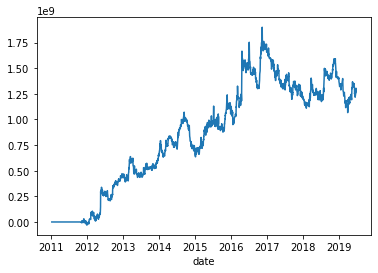

                tsmom-macdnma-commod_mkts-2-120-5-0.2
sharp_ratio_1y                          -8.183674e-03
sharp_ratio_2y                          -3.329678e-02
sharp_ratio_3y                          -1.768488e-01
sharp_ratio_4y                           1.787620e-01
sharp_ratio_5y                           2.411648e-01
sharp_ratio_6y                           3.382918e-01
sharp_ratio_8y                           4.413208e-01
std_pnl_1y                               2.278087e+07
std_pnl_2y                               2.366499e+07
std_pnl_3y                               2.551601e+07
std_pnl_4y                               2.854363e+07
std_pnl_5y                               2.715975e+07
std_pnl_6y                               2.558121e+07
std_pnl_8y                               2.364169e+07


<ipython-input-7-ae21987a4c76>:202: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  tdf['date'] = adf['date']


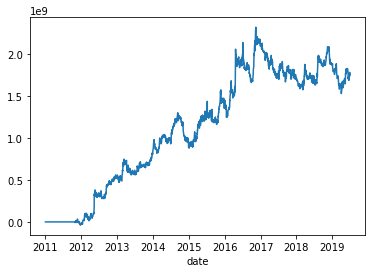

                tsmom-macdnma-commod_mkts-2-120-5-0.2
sharp_ratio_1y                           4.079604e-02
sharp_ratio_2y                           5.340684e-02
sharp_ratio_3y                          -8.665423e-02
sharp_ratio_4y                           2.737164e-01
sharp_ratio_5y                           3.436485e-01
sharp_ratio_6y                           4.595373e-01
sharp_ratio_8y                           5.724066e-01
std_pnl_1y                               2.418259e+07
std_pnl_2y                               2.522039e+07
std_pnl_3y                               2.693546e+07
std_pnl_4y                               3.011718e+07
std_pnl_5y                               2.870516e+07
std_pnl_6y                               2.706292e+07
std_pnl_8y                               2.501452e+07


C:\Anaconda3\lib\site-packages\pandas\core\indexing.py:670: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  iloc._setitem_with_indexer(indexer, value)
<ipython-input-7-ae21987a4c76>:202: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  tdf['date'] = adf['date']


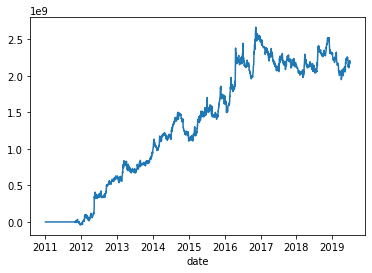

                tsmom-macdnma-commod_mkts-2-120-5-0.2
sharp_ratio_1y                           9.532829e-02
sharp_ratio_2y                           1.355292e-01
sharp_ratio_3y                           1.033847e-02
sharp_ratio_4y                           3.583153e-01
sharp_ratio_5y                           4.322451e-01
sharp_ratio_6y                           5.635220e-01
sharp_ratio_8y                           6.850524e-01
std_pnl_1y                               2.527601e+07
std_pnl_2y                               2.648065e+07
std_pnl_3y                               2.802145e+07
std_pnl_4y                               3.125448e+07
std_pnl_5y                               2.982371e+07
std_pnl_6y                               2.814231e+07
std_pnl_8y                               2.601810e+07


C:\Anaconda3\lib\site-packages\pandas\core\indexing.py:670: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  iloc._setitem_with_indexer(indexer, value)
<ipython-input-7-ae21987a4c76>:202: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  tdf['date'] = adf['date']


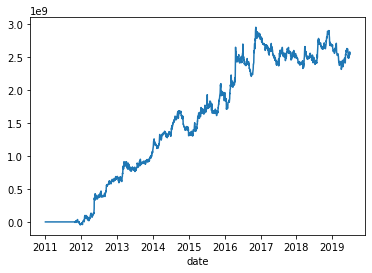

                tsmom-macdnma-commod_mkts-2-120-5-0.2
sharp_ratio_1y                           1.471896e-01
sharp_ratio_2y                           2.055173e-01
sharp_ratio_3y                           1.005183e-01
sharp_ratio_4y                           4.323279e-01
sharp_ratio_5y                           5.071698e-01
sharp_ratio_6y                           6.496867e-01
sharp_ratio_8y                           7.784040e-01
std_pnl_1y                               2.615800e+07
std_pnl_2y                               2.753374e+07
std_pnl_3y                               2.891343e+07
std_pnl_4y                               3.215140e+07
std_pnl_5y                               3.070150e+07
std_pnl_6y                               2.899388e+07
std_pnl_8y                               2.681391e+07


C:\Anaconda3\lib\site-packages\pandas\core\indexing.py:670: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  iloc._setitem_with_indexer(indexer, value)
<ipython-input-7-ae21987a4c76>:202: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  tdf['date'] = adf['date']


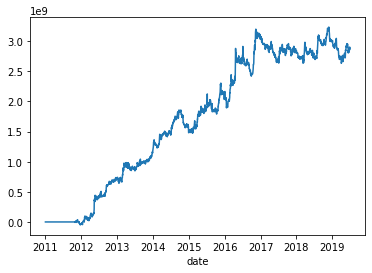

                tsmom-macdnma-commod_mkts-2-120-5-0.2
sharp_ratio_1y                           1.953008e-01
sharp_ratio_2y                           2.628806e-01
sharp_ratio_3y                           1.797489e-01
sharp_ratio_4y                           4.966690e-01
sharp_ratio_5y                           5.701279e-01
sharp_ratio_6y                           7.205014e-01
sharp_ratio_8y                           8.549441e-01
std_pnl_1y                               2.688337e+07
std_pnl_2y                               2.842662e+07
std_pnl_3y                               2.967615e+07
std_pnl_4y                               3.290191e+07
std_pnl_5y                               3.143054e+07
std_pnl_6y                               2.970361e+07
std_pnl_8y                               2.748040e+07


C:\Anaconda3\lib\site-packages\pandas\core\indexing.py:670: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  iloc._setitem_with_indexer(indexer, value)
<ipython-input-7-ae21987a4c76>:202: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  tdf['date'] = adf['date']


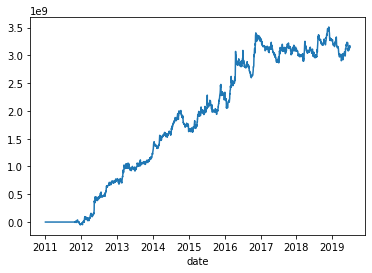

                tsmom-macdnma-commod_mkts-2-120-5-0.2
sharp_ratio_1y                           2.403242e-01
sharp_ratio_2y                           3.095306e-01
sharp_ratio_3y                           2.479005e-01
sharp_ratio_4y                           5.526345e-01
sharp_ratio_5y                           6.231353e-01
sharp_ratio_6y                           7.789279e-01
sharp_ratio_8y                           9.178114e-01
std_pnl_1y                               2.748779e+07
std_pnl_2y                               2.919181e+07
std_pnl_3y                               3.034526e+07
std_pnl_4y                               3.355467e+07
std_pnl_5y                               3.205974e+07
std_pnl_6y                               3.031712e+07
std_pnl_8y                               2.805869e+07


C:\Anaconda3\lib\site-packages\pandas\core\indexing.py:670: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  iloc._setitem_with_indexer(indexer, value)
<ipython-input-7-ae21987a4c76>:202: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  tdf['date'] = adf['date']


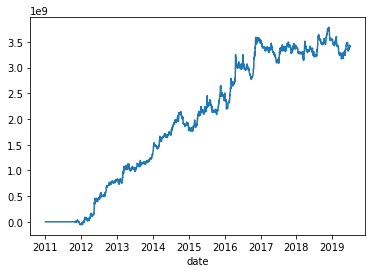

                tsmom-macdnma-commod_mkts-4-120-5-0.2
sharp_ratio_1y                           2.539194e-01
sharp_ratio_2y                           3.431026e-01
sharp_ratio_3y                           3.021170e-01
sharp_ratio_4y                           5.859799e-01
sharp_ratio_5y                           6.666554e-01
sharp_ratio_6y                           8.288113e-01
sharp_ratio_8y                           9.705580e-01
std_pnl_1y                               2.840475e+07
std_pnl_2y                               3.012361e+07
std_pnl_3y                               3.107537e+07
std_pnl_4y                               3.422756e+07
std_pnl_5y                               3.276186e+07
std_pnl_6y                               3.103207e+07
std_pnl_8y                               2.872549e+07


<ipython-input-7-ae21987a4c76>:202: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  tdf['date'] = adf['date']


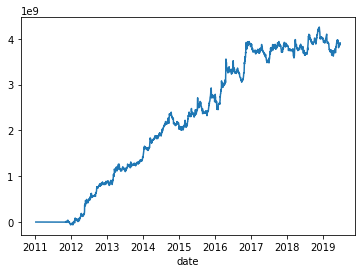

                tsmom-macdnma-commod_mkts-4-120-5-0.2
sharp_ratio_1y                           3.548298e-01
sharp_ratio_2y                           4.271303e-01
sharp_ratio_3y                           4.337917e-01
sharp_ratio_4y                           6.910464e-01
sharp_ratio_5y                           7.584806e-01
sharp_ratio_6y                           9.231487e-01
sharp_ratio_8y                           1.069506e+00
std_pnl_1y                               2.944696e+07
std_pnl_2y                               3.148068e+07
std_pnl_3y                               3.230042e+07
std_pnl_4y                               3.536821e+07
std_pnl_5y                               3.385225e+07
std_pnl_6y                               3.210660e+07
std_pnl_8y                               2.974117e+07


<ipython-input-7-ae21987a4c76>:202: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  tdf['date'] = adf['date']


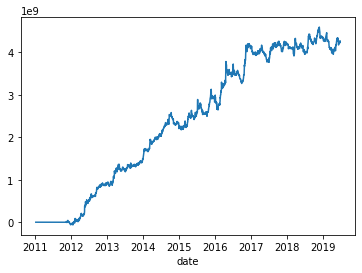

                tsmom-macdnma-commod_mkts-4-120-5-0.2
sharp_ratio_1y                           4.430435e-01
sharp_ratio_2y                           4.829663e-01
sharp_ratio_3y                           5.261683e-01
sharp_ratio_4y                           7.717665e-01
sharp_ratio_5y                           8.244156e-01
sharp_ratio_6y                           9.881209e-01
sharp_ratio_8y                           1.135911e+00
std_pnl_1y                               3.016475e+07
std_pnl_2y                               3.248083e+07
std_pnl_3y                               3.330175e+07
std_pnl_4y                               3.632366e+07
std_pnl_5y                               3.475254e+07
std_pnl_6y                               3.298617e+07
std_pnl_8y                               3.057515e+07


<ipython-input-7-ae21987a4c76>:202: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  tdf['date'] = adf['date']


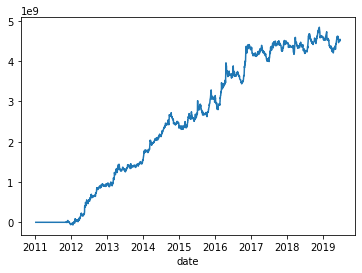

                tsmom-macdnma-commod_mkts-4-120-5-0.2
sharp_ratio_1y                           5.163061e-01
sharp_ratio_2y                           5.196809e-01
sharp_ratio_3y                           5.902038e-01
sharp_ratio_4y                           8.329067e-01
sharp_ratio_5y                           8.726800e-01
sharp_ratio_6y                           1.034517e+00
sharp_ratio_8y                           1.182220e+00
std_pnl_1y                               3.067873e+07
std_pnl_2y                               3.325363e+07
std_pnl_3y                               3.414547e+07
std_pnl_4y                               3.714728e+07
std_pnl_5y                               3.552416e+07
std_pnl_6y                               3.373378e+07
std_pnl_8y                               3.128747e+07


<ipython-input-7-ae21987a4c76>:202: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  tdf['date'] = adf['date']


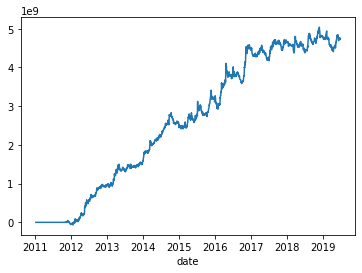

                tsmom-macdnma-commod_mkts-4-120-5-0.2
sharp_ratio_1y                           5.745810e-01
sharp_ratio_2y                           5.422323e-01
sharp_ratio_3y                           6.334769e-01
sharp_ratio_4y                           8.783756e-01
sharp_ratio_5y                           9.081627e-01
sharp_ratio_6y                           1.068041e+00
sharp_ratio_8y                           1.214936e+00
std_pnl_1y                               3.106410e+07
std_pnl_2y                               3.387605e+07
std_pnl_3y                               3.486935e+07
std_pnl_4y                               3.786723e+07
std_pnl_5y                               3.619838e+07
std_pnl_6y                               3.438279e+07
std_pnl_8y                               3.191026e+07


<ipython-input-7-ae21987a4c76>:202: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  tdf['date'] = adf['date']


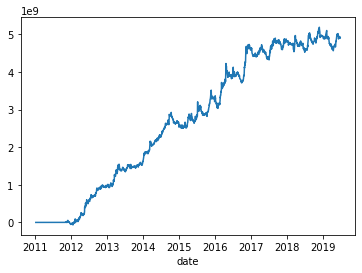

                tsmom-macdnma-commod_mkts-4-120-5-0.2
sharp_ratio_1y                           6.196546e-01
sharp_ratio_2y                           5.539011e-01
sharp_ratio_3y                           6.613959e-01
sharp_ratio_4y                           9.114621e-01
sharp_ratio_5y                           9.341453e-01
sharp_ratio_6y                           1.092168e+00
sharp_ratio_8y                           1.237879e+00
std_pnl_1y                               3.136709e+07
std_pnl_2y                               3.439375e+07
std_pnl_3y                               3.549867e+07
std_pnl_4y                               3.850317e+07
std_pnl_5y                               3.679544e+07
std_pnl_6y                               3.495496e+07
std_pnl_8y                               3.246376e+07


<ipython-input-7-ae21987a4c76>:202: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  tdf['date'] = adf['date']


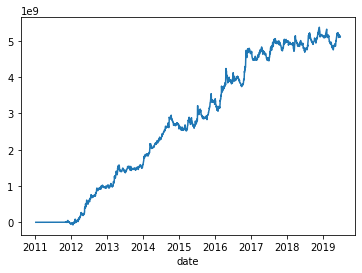

                tsmom-macdnma-commod_mkts-8-120-5-0.2
sharp_ratio_1y                           6.916193e-01
sharp_ratio_2y                           6.155109e-01
sharp_ratio_3y                           7.658662e-01
sharp_ratio_4y                           9.902455e-01
sharp_ratio_5y                           9.851795e-01
sharp_ratio_6y                           1.128470e+00
sharp_ratio_8y                           1.264820e+00
std_pnl_1y                               3.210983e+07
std_pnl_2y                               3.519875e+07
std_pnl_3y                               3.640091e+07
std_pnl_4y                               3.920144e+07
std_pnl_5y                               3.748280e+07
std_pnl_6y                               3.564656e+07
std_pnl_8y                               3.309131e+07


<ipython-input-7-ae21987a4c76>:202: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  tdf['date'] = adf['date']


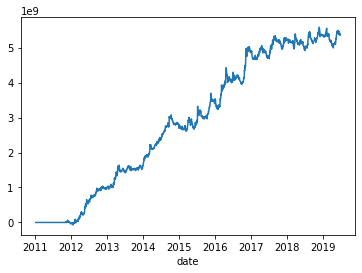

                tsmom-macdnma-commod_mkts-8-120-5-0.2
sharp_ratio_1y                           7.491826e-01
sharp_ratio_2y                           6.120105e-01
sharp_ratio_3y                           7.876985e-01
sharp_ratio_4y                           1.033758e+00
sharp_ratio_5y                           1.017603e+00
sharp_ratio_6y                           1.155299e+00
sharp_ratio_8y                           1.285940e+00
std_pnl_1y                               3.257817e+07
std_pnl_2y                               3.608627e+07
std_pnl_3y                               3.760672e+07
std_pnl_4y                               4.041186e+07
std_pnl_5y                               3.862162e+07
std_pnl_6y                               3.672225e+07
std_pnl_8y                               3.414318e+07


<ipython-input-7-ae21987a4c76>:202: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  tdf['date'] = adf['date']


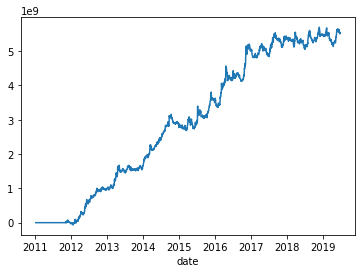

                tsmom-macdnma-commod_mkts-8-120-5-0.2
sharp_ratio_1y                           7.743266e-01
sharp_ratio_2y                           5.827422e-01
sharp_ratio_3y                           7.760411e-01
sharp_ratio_4y                           1.045334e+00
sharp_ratio_5y                           1.028993e+00
sharp_ratio_6y                           1.163224e+00
sharp_ratio_8y                           1.288478e+00
std_pnl_1y                               3.291723e+07
std_pnl_2y                               3.675683e+07
std_pnl_3y                               3.852781e+07
std_pnl_4y                               4.137062e+07
std_pnl_5y                               3.953025e+07
std_pnl_6y                               3.757878e+07
std_pnl_8y                               3.499821e+07


<ipython-input-7-ae21987a4c76>:202: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  tdf['date'] = adf['date']


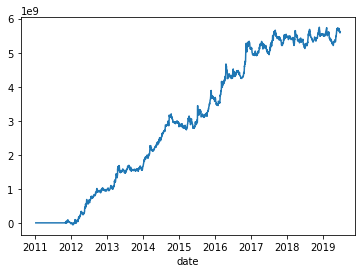

                tsmom-macdnma-commod_mkts-8-120-5-0.2
sharp_ratio_1y                           7.839969e-01
sharp_ratio_2y                           5.408980e-01
sharp_ratio_3y                           7.498232e-01
sharp_ratio_4y                           1.040664e+00
sharp_ratio_5y                           1.029647e+00
sharp_ratio_6y                           1.161133e+00
sharp_ratio_8y                           1.280573e+00
std_pnl_1y                               3.319068e+07
std_pnl_2y                               3.727254e+07
std_pnl_3y                               3.925332e+07
std_pnl_4y                               4.215446e+07
std_pnl_5y                               4.028085e+07
std_pnl_6y                               3.829083e+07
std_pnl_8y                               3.571475e+07


<ipython-input-7-ae21987a4c76>:202: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  tdf['date'] = adf['date']


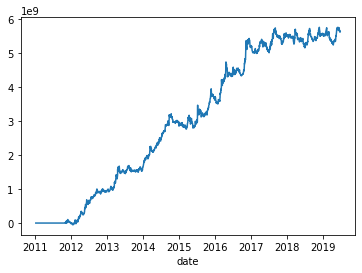

                tsmom-macdnma-commod_mkts-8-120-5-0.2
sharp_ratio_1y                           7.854436e-01
sharp_ratio_2y                           4.939185e-01
sharp_ratio_3y                           7.183840e-01
sharp_ratio_4y                           1.028287e+00
sharp_ratio_5y                           1.025201e+00
sharp_ratio_6y                           1.154168e+00
sharp_ratio_8y                           1.267076e+00
std_pnl_1y                               3.341868e+07
std_pnl_2y                               3.766683e+07
std_pnl_3y                               3.983891e+07
std_pnl_4y                               4.281259e+07
std_pnl_5y                               4.092005e+07
std_pnl_6y                               3.890389e+07
std_pnl_8y                               3.632874e+07


<ipython-input-7-ae21987a4c76>:202: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  tdf['date'] = adf['date']


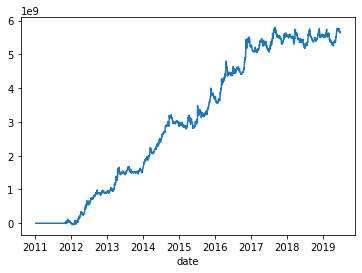

                tsmom-macdnma-commod_mkts-8-120-5-0.2
sharp_ratio_1y                           7.818233e-01
sharp_ratio_2y                           4.462123e-01
sharp_ratio_3y                           6.862856e-01
sharp_ratio_4y                           1.012729e+00
sharp_ratio_5y                           1.018784e+00
sharp_ratio_6y                           1.145389e+00
sharp_ratio_8y                           1.251022e+00
std_pnl_1y                               3.360670e+07
std_pnl_2y                               3.796469e+07
std_pnl_3y                               4.032114e+07
std_pnl_4y                               4.337852e+07
std_pnl_5y                               4.147874e+07
std_pnl_6y                               3.944679e+07
std_pnl_8y                               3.686452e+07


<ipython-input-7-ae21987a4c76>:202: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  tdf['date'] = adf['date']


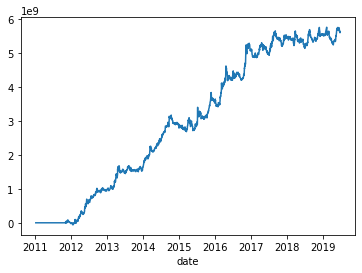

                tsmom-macdnma-commod_mkts-12-120-5-0.2
sharp_ratio_1y                            7.886129e-01
sharp_ratio_2y                            5.652913e-01
sharp_ratio_3y                            7.818192e-01
sharp_ratio_4y                            1.067436e+00
sharp_ratio_5y                            1.043211e+00
sharp_ratio_6y                            1.169170e+00
sharp_ratio_8y                            1.284527e+00
std_pnl_1y                                3.333455e+07
std_pnl_2y                                3.744863e+07
std_pnl_3y                                3.945730e+07
std_pnl_4y                                4.224195e+07
std_pnl_5y                                4.034667e+07
std_pnl_6y                                3.834344e+07
std_pnl_8y                                3.574451e+07


<ipython-input-7-ae21987a4c76>:202: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  tdf['date'] = adf['date']


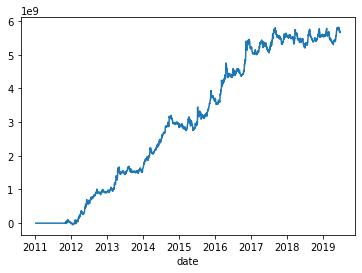

                tsmom-macdnma-commod_mkts-12-120-5-0.2
sharp_ratio_1y                            7.861303e-01
sharp_ratio_2y                            4.805037e-01
sharp_ratio_3y                            7.201662e-01
sharp_ratio_4y                            1.042216e+00
sharp_ratio_5y                            1.032895e+00
sharp_ratio_6y                            1.155610e+00
sharp_ratio_8y                            1.259168e+00
std_pnl_1y                                3.373242e+07
std_pnl_2y                                3.819587e+07
std_pnl_3y                                4.047079e+07
std_pnl_4y                                4.336118e+07
std_pnl_5y                                4.141764e+07
std_pnl_6y                                3.936254e+07
std_pnl_8y                                3.678483e+07


<ipython-input-7-ae21987a4c76>:202: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  tdf['date'] = adf['date']


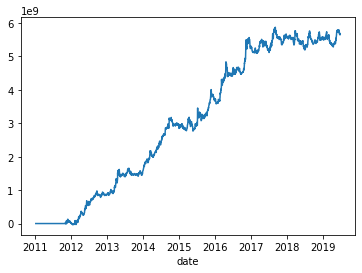

                tsmom-macdnma-commod_mkts-12-120-5-0.2
sharp_ratio_1y                            7.725548e-01
sharp_ratio_2y                            3.930803e-01
sharp_ratio_3y                            6.559548e-01
sharp_ratio_4y                            1.008651e+00
sharp_ratio_5y                            1.017705e+00
sharp_ratio_6y                            1.138154e+00
sharp_ratio_8y                            1.228264e+00
std_pnl_1y                                3.402106e+07
std_pnl_2y                                3.866612e+07
std_pnl_3y                                4.117882e+07
std_pnl_4y                                4.420979e+07
std_pnl_5y                                4.225298e+07
std_pnl_6y                                4.017919e+07
std_pnl_8y                                3.760506e+07


<ipython-input-7-ae21987a4c76>:202: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  tdf['date'] = adf['date']


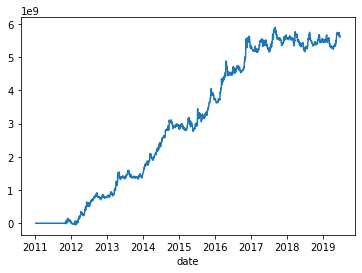

                tsmom-macdnma-commod_mkts-12-120-5-0.2
sharp_ratio_1y                            7.516874e-01
sharp_ratio_2y                            3.136546e-01
sharp_ratio_3y                            5.980784e-01
sharp_ratio_4y                            9.763204e-01
sharp_ratio_5y                            1.004626e+00
sharp_ratio_6y                            1.123323e+00
sharp_ratio_8y                            1.198581e+00
std_pnl_1y                                3.420120e+07
std_pnl_2y                                3.893685e+07
std_pnl_3y                                4.168863e+07
std_pnl_4y                                4.488786e+07
std_pnl_5y                                4.293969e+07
std_pnl_6y                                4.086816e+07
std_pnl_8y                                3.827318e+07


<ipython-input-7-ae21987a4c76>:202: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  tdf['date'] = adf['date']


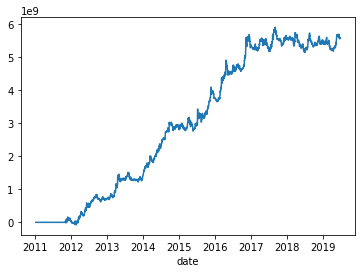

                tsmom-macdnma-commod_mkts-12-120-5-0.2
sharp_ratio_1y                            7.259914e-01
sharp_ratio_2y                            2.466904e-01
sharp_ratio_3y                            5.485415e-01
sharp_ratio_4y                            9.474144e-01
sharp_ratio_5y                            9.954734e-01
sharp_ratio_6y                            1.112343e+00
sharp_ratio_8y                            1.171931e+00
std_pnl_1y                                3.426924e+07
std_pnl_2y                                3.905984e+07
std_pnl_3y                                4.205723e+07
std_pnl_4y                                4.544658e+07
std_pnl_5y                                4.351405e+07
std_pnl_6y                                4.145445e+07
std_pnl_8y                                3.882153e+07


<ipython-input-7-ae21987a4c76>:202: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  tdf['date'] = adf['date']


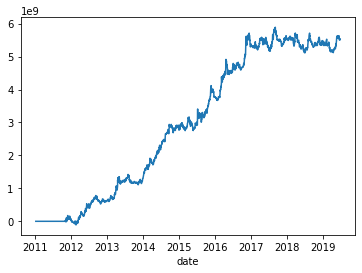

                tsmom-macdnma-commod_mkts-12-120-5-0.2
sharp_ratio_1y                            6.942471e-01
sharp_ratio_2y                            1.909500e-01
sharp_ratio_3y                            5.067652e-01
sharp_ratio_4y                            9.210474e-01
sharp_ratio_5y                            9.891550e-01
sharp_ratio_6y                            1.103656e+00
sharp_ratio_8y                            1.147536e+00
std_pnl_1y                                3.424420e+07
std_pnl_2y                                3.907138e+07
std_pnl_3y                                4.232225e+07
std_pnl_4y                                4.591002e+07
std_pnl_5y                                4.398708e+07
std_pnl_6y                                4.194145e+07
std_pnl_8y                                3.926409e+07


<ipython-input-7-ae21987a4c76>:202: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  tdf['date'] = adf['date']


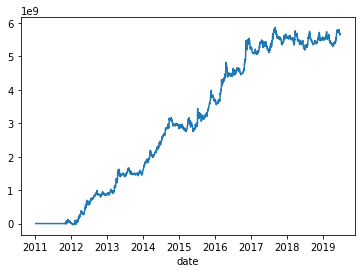

                tsmom-macdnma-commod_mkts-16-120-5-0.2
sharp_ratio_1y                            7.721224e-01
sharp_ratio_2y                            3.985505e-01
sharp_ratio_3y                            6.599036e-01
sharp_ratio_4y                            1.014625e+00
sharp_ratio_5y                            1.019274e+00
sharp_ratio_6y                            1.139196e+00
sharp_ratio_8y                            1.228381e+00
std_pnl_1y                                3.410399e+07
std_pnl_2y                                3.884411e+07
std_pnl_3y                                4.127414e+07
std_pnl_4y                                4.423731e+07
std_pnl_5y                                4.224773e+07
std_pnl_6y                                4.015773e+07
std_pnl_8y                                3.760154e+07


<ipython-input-7-ae21987a4c76>:202: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  tdf['date'] = adf['date']


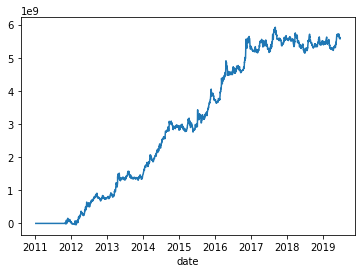

                tsmom-macdnma-commod_mkts-16-120-5-0.2
sharp_ratio_1y                            7.395754e-01
sharp_ratio_2y                            2.701482e-01
sharp_ratio_3y                            5.623456e-01
sharp_ratio_4y                            9.605599e-01
sharp_ratio_5y                            9.954520e-01
sharp_ratio_6y                            1.114667e+00
sharp_ratio_8y                            1.181299e+00
std_pnl_1y                                3.442278e+07
std_pnl_2y                                3.930028e+07
std_pnl_3y                                4.199881e+07
std_pnl_4y                                4.520008e+07
std_pnl_5y                                4.321473e+07
std_pnl_6y                                4.113188e+07
std_pnl_8y                                3.857093e+07


<ipython-input-7-ae21987a4c76>:202: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  tdf['date'] = adf['date']


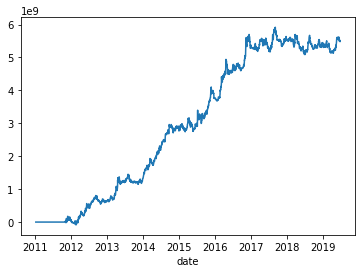

                tsmom-macdnma-commod_mkts-16-120-5-0.2
sharp_ratio_1y                            6.943596e-01
sharp_ratio_2y                            1.659648e-01
sharp_ratio_3y                            4.833583e-01
sharp_ratio_4y                            9.153903e-01
sharp_ratio_5y                            9.809877e-01
sharp_ratio_6y                            1.099132e+00
sharp_ratio_8y                            1.142035e+00
std_pnl_1y                                3.450916e+07
std_pnl_2y                                3.942416e+07
std_pnl_3y                                4.242526e+07
std_pnl_4y                                4.590597e+07
std_pnl_5y                                4.394148e+07
std_pnl_6y                                4.188421e+07
std_pnl_8y                                3.928284e+07


<ipython-input-7-ae21987a4c76>:202: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  tdf['date'] = adf['date']


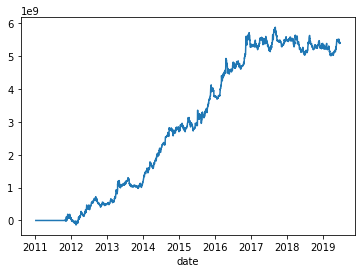

                tsmom-macdnma-commod_mkts-16-120-5-0.2
sharp_ratio_1y                            6.382506e-01
sharp_ratio_2y                            8.333118e-02
sharp_ratio_3y                            4.236498e-01
sharp_ratio_4y                            8.771566e-01
sharp_ratio_5y                            9.726052e-01
sharp_ratio_6y                            1.087209e+00
sharp_ratio_8y                            1.107533e+00
std_pnl_1y                                3.441657e+07
std_pnl_2y                                3.932619e+07
std_pnl_3y                                4.267660e+07
std_pnl_4y                                4.642340e+07
std_pnl_5y                                4.445858e+07
std_pnl_6y                                4.242051e+07
std_pnl_8y                                3.977185e+07


<ipython-input-7-ae21987a4c76>:202: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  tdf['date'] = adf['date']


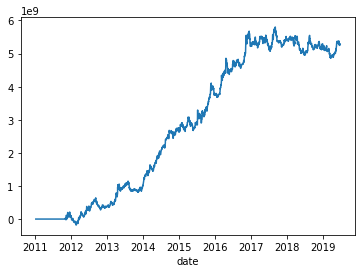

                tsmom-macdnma-commod_mkts-16-120-5-0.2
sharp_ratio_1y                            5.767025e-01
sharp_ratio_2y                            9.579213e-03
sharp_ratio_3y                            3.792108e-01
sharp_ratio_4y                            8.406504e-01
sharp_ratio_5y                            9.650014e-01
sharp_ratio_6y                            1.074039e+00
sharp_ratio_8y                            1.075535e+00
std_pnl_1y                                3.425161e+07
std_pnl_2y                                3.908743e+07
std_pnl_3y                                4.280092e+07
std_pnl_4y                                4.673757e+07
std_pnl_5y                                4.474513e+07
std_pnl_6y                                4.272333e+07
std_pnl_8y                                4.003770e+07


<ipython-input-7-ae21987a4c76>:202: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  tdf['date'] = adf['date']


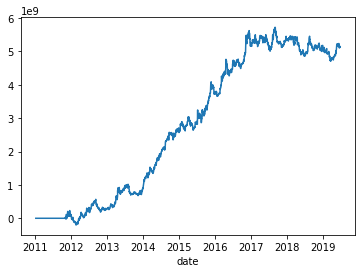

                tsmom-macdnma-commod_mkts-16-120-5-0.2
sharp_ratio_1y                            5.096054e-01
sharp_ratio_2y                           -6.702070e-02
sharp_ratio_3y                            3.428646e-01
sharp_ratio_4y                            8.008390e-01
sharp_ratio_5y                            9.533847e-01
sharp_ratio_6y                            1.058538e+00
sharp_ratio_8y                            1.047258e+00
std_pnl_1y                                3.404492e+07
std_pnl_2y                                3.873949e+07
std_pnl_3y                                4.277352e+07
std_pnl_4y                                4.679752e+07
std_pnl_5y                                4.475405e+07
std_pnl_6y                                4.275557e+07
std_pnl_8y                                4.005044e+07


<ipython-input-7-ae21987a4c76>:202: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  tdf['date'] = adf['date']


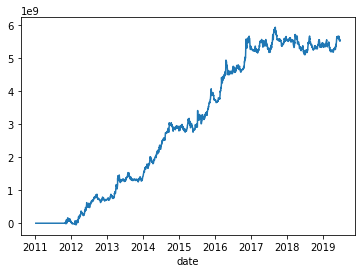

                tsmom-macdnma-commod_mkts-20-120-5-0.2
sharp_ratio_1y                            7.219725e-01
sharp_ratio_2y                            2.085945e-01
sharp_ratio_3y                            5.118752e-01
sharp_ratio_4y                            9.335270e-01
sharp_ratio_5y                            9.821515e-01
sharp_ratio_6y                            1.102778e+00
sharp_ratio_8y                            1.157990e+00
std_pnl_1y                                3.461682e+07
std_pnl_2y                                3.956469e+07
std_pnl_3y                                4.227067e+07
std_pnl_4y                                4.555531e+07
std_pnl_5y                                4.355522e+07
std_pnl_6y                                4.147793e+07
std_pnl_8y                                3.893699e+07


<ipython-input-7-ae21987a4c76>:202: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  tdf['date'] = adf['date']


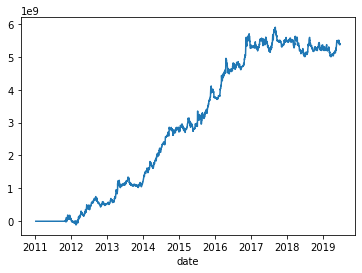

                tsmom-macdnma-commod_mkts-20-120-5-0.2
sharp_ratio_1y                            6.509368e-01
sharp_ratio_2y                            6.848966e-02
sharp_ratio_3y                            4.064835e-01
sharp_ratio_4y                            8.729448e-01
sharp_ratio_5y                            9.641801e-01
sharp_ratio_6y                            1.083474e+00
sharp_ratio_8y                            1.106152e+00
std_pnl_1y                                3.467187e+07
std_pnl_2y                                3.959734e+07
std_pnl_3y                                4.268562e+07
std_pnl_4y                                4.633871e+07
std_pnl_5y                                4.435411e+07
std_pnl_6y                                4.231101e+07
std_pnl_8y                                3.972892e+07


<ipython-input-7-ae21987a4c76>:202: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  tdf['date'] = adf['date']


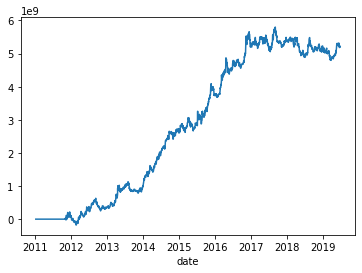

                tsmom-macdnma-commod_mkts-20-120-5-0.2
sharp_ratio_1y                            5.696994e-01
sharp_ratio_2y                           -4.251971e-02
sharp_ratio_3y                            3.370308e-01
sharp_ratio_4y                            8.227211e-01
sharp_ratio_5y                            9.533530e-01
sharp_ratio_6y                            1.064653e+00
sharp_ratio_8y                            1.060355e+00
std_pnl_1y                                3.446798e+07
std_pnl_2y                                3.928788e+07
std_pnl_3y                                4.286039e+07
std_pnl_4y                                4.676547e+07
std_pnl_5y                                4.474786e+07
std_pnl_6y                                4.271671e+07
std_pnl_8y                                4.009755e+07


<ipython-input-7-ae21987a4c76>:202: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  tdf['date'] = adf['date']


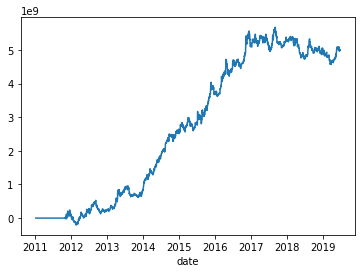

                tsmom-macdnma-commod_mkts-20-120-5-0.2
sharp_ratio_1y                            4.767433e-01
sharp_ratio_2y                           -1.557471e-01
sharp_ratio_3y                            2.850363e-01
sharp_ratio_4y                            7.675216e-01
sharp_ratio_5y                            9.358071e-01
sharp_ratio_6y                            1.038932e+00
sharp_ratio_8y                            1.019133e+00
std_pnl_1y                                3.412167e+07
std_pnl_2y                                3.875469e+07
std_pnl_3y                                4.276891e+07
std_pnl_4y                                4.672447e+07
std_pnl_5y                                4.464143e+07
std_pnl_6y                                4.263922e+07
std_pnl_8y                                3.999896e+07


<ipython-input-7-ae21987a4c76>:202: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  tdf['date'] = adf['date']


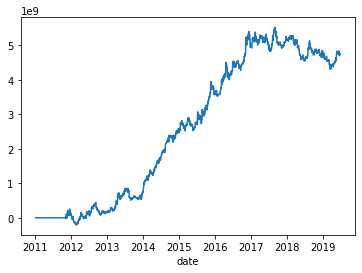

                tsmom-macdnma-commod_mkts-20-120-5-0.2
sharp_ratio_1y                            3.655505e-01
sharp_ratio_2y                           -2.624636e-01
sharp_ratio_3y                            2.500042e-01
sharp_ratio_4y                            7.108855e-01
sharp_ratio_5y                            9.010759e-01
sharp_ratio_6y                            1.009004e+00
sharp_ratio_8y                            9.830670e-01
std_pnl_1y                                3.362530e+07
std_pnl_2y                                3.800887e+07
std_pnl_3y                                4.229588e+07
std_pnl_4y                                4.616743e+07
std_pnl_5y                                4.396644e+07
std_pnl_6y                                4.200749e+07
std_pnl_8y                                3.936383e+07


<ipython-input-7-ae21987a4c76>:202: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  tdf['date'] = adf['date']


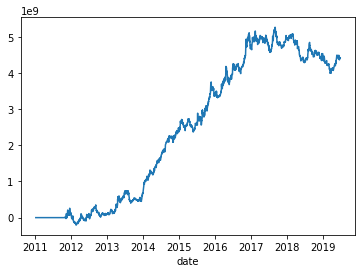

                tsmom-macdnma-commod_mkts-20-120-5-0.2
sharp_ratio_1y                            2.416257e-01
sharp_ratio_2y                           -3.424795e-01
sharp_ratio_3y                            2.350757e-01
sharp_ratio_4y                            6.608324e-01
sharp_ratio_5y                            8.461621e-01
sharp_ratio_6y                            9.733527e-01
sharp_ratio_8y                            9.383781e-01
std_pnl_1y                                3.294613e+07
std_pnl_2y                                3.708634e+07
std_pnl_3y                                4.144220e+07
std_pnl_4y                                4.521469e+07
std_pnl_5y                                4.288309e+07
std_pnl_6y                                4.096957e+07
std_pnl_8y                                3.834027e+07


<ipython-input-7-ae21987a4c76>:202: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  tdf['date'] = adf['date']


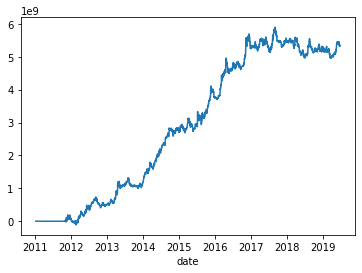

                tsmom-macdnma-commod_mkts-24-120-5-0.2
sharp_ratio_1y                            6.414151e-01
sharp_ratio_2y                            3.170832e-02
sharp_ratio_3y                            3.761598e-01
sharp_ratio_4y                            8.568494e-01
sharp_ratio_5y                            9.552896e-01
sharp_ratio_6y                            1.076368e+00
sharp_ratio_8y                            1.093608e+00
std_pnl_1y                                3.480768e+07
std_pnl_2y                                3.971191e+07
std_pnl_3y                                4.274333e+07
std_pnl_4y                                4.641884e+07
std_pnl_5y                                4.442020e+07
std_pnl_6y                                4.237987e+07
std_pnl_8y                                3.982794e+07


<ipython-input-7-ae21987a4c76>:202: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  tdf['date'] = adf['date']


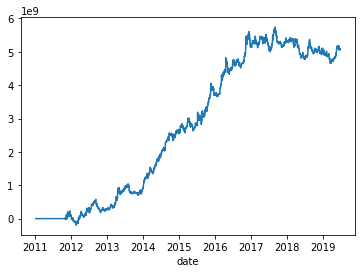

                tsmom-macdnma-commod_mkts-24-120-5-0.2
sharp_ratio_1y                            5.340238e-01
sharp_ratio_2y                           -1.240360e-01
sharp_ratio_3y                            2.830665e-01
sharp_ratio_4y                            7.877276e-01
sharp_ratio_5y                            9.375138e-01
sharp_ratio_6y                            1.046475e+00
sharp_ratio_8y                            1.031376e+00
std_pnl_1y                                3.452197e+07
std_pnl_2y                                3.924783e+07
std_pnl_3y                                4.289379e+07
std_pnl_4y                                4.680532e+07
std_pnl_5y                                4.475184e+07
std_pnl_6y                                4.271765e+07
std_pnl_8y                                4.014062e+07


<ipython-input-7-ae21987a4c76>:202: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  tdf['date'] = adf['date']


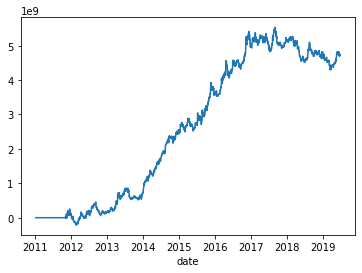

                tsmom-macdnma-commod_mkts-24-120-5-0.2
sharp_ratio_1y                            3.933422e-01
sharp_ratio_2y                           -2.865529e-01
sharp_ratio_3y                            2.160275e-01
sharp_ratio_4y                            7.084669e-01
sharp_ratio_5y                            9.009485e-01
sharp_ratio_6y                            1.001211e+00
sharp_ratio_8y                            9.745655e-01
std_pnl_1y                                3.390958e+07
std_pnl_2y                                3.840157e+07
std_pnl_3y                                4.253468e+07
std_pnl_4y                                4.635457e+07
std_pnl_5y                                4.420304e+07
std_pnl_6y                                4.221932e+07
std_pnl_8y                                3.962032e+07


<ipython-input-7-ae21987a4c76>:202: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  tdf['date'] = adf['date']


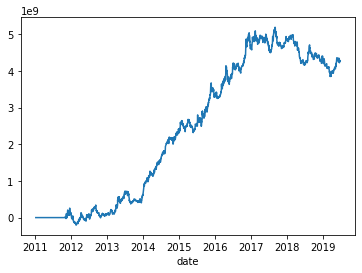

                tsmom-macdnma-commod_mkts-24-120-5-0.2
sharp_ratio_1y                            2.208682e-01
sharp_ratio_2y                           -4.190986e-01
sharp_ratio_3y                            1.806409e-01
sharp_ratio_4y                            6.332240e-01
sharp_ratio_5y                            8.280595e-01
sharp_ratio_6y                            9.443164e-01
sharp_ratio_8y                            9.101861e-01
std_pnl_1y                                3.302547e+07
std_pnl_2y                                3.725097e+07
std_pnl_3y                                4.146884e+07
std_pnl_4y                                4.510068e+07
std_pnl_5y                                4.279241e+07
std_pnl_6y                                4.088635e+07
std_pnl_8y                                3.828665e+07


<ipython-input-7-ae21987a4c76>:202: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  tdf['date'] = adf['date']


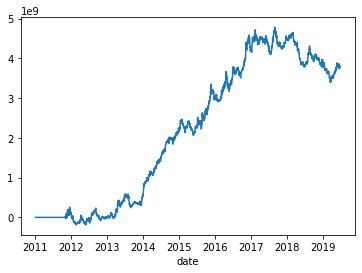

                tsmom-macdnma-commod_mkts-24-120-5-0.2
sharp_ratio_1y                            2.173082e-02
sharp_ratio_2y                           -5.031487e-01
sharp_ratio_3y                            1.675558e-01
sharp_ratio_4y                            5.721552e-01
sharp_ratio_5y                            7.414805e-01
sharp_ratio_6y                            8.863405e-01
sharp_ratio_8y                            8.412982e-01
std_pnl_1y                                3.213130e+07
std_pnl_2y                                3.613627e+07
std_pnl_3y                                4.005001e+07
std_pnl_4y                                4.353685e+07
std_pnl_5y                                4.117301e+07
std_pnl_6y                                3.933294e+07
std_pnl_8y                                3.679020e+07


<ipython-input-7-ae21987a4c76>:202: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  tdf['date'] = adf['date']


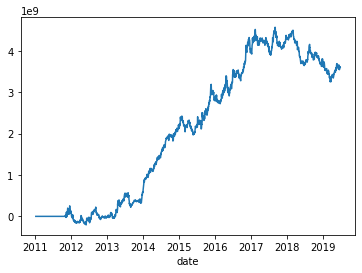

                tsmom-macdnma-commod_mkts-24-120-5-0.2
sharp_ratio_1y                           -9.263869e-02
sharp_ratio_2y                           -4.994588e-01
sharp_ratio_3y                            2.041070e-01
sharp_ratio_4y                            5.574843e-01
sharp_ratio_5y                            7.012601e-01
sharp_ratio_6y                            8.689233e-01
sharp_ratio_8y                            8.254150e-01
std_pnl_1y                                3.149945e+07
std_pnl_2y                                3.527082e+07
std_pnl_3y                                3.876033e+07
std_pnl_4y                                4.209804e+07
std_pnl_5y                                3.981582e+07
std_pnl_6y                                3.800382e+07
std_pnl_8y                                3.554747e+07


<ipython-input-7-ae21987a4c76>:202: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  tdf['date'] = adf['date']


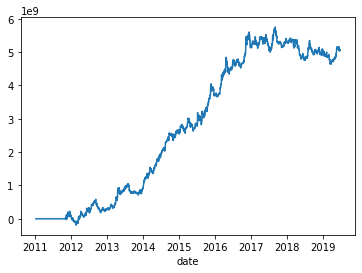

                tsmom-macdnma-commod_mkts-28-120-5-0.2
sharp_ratio_1y                            5.407474e-01
sharp_ratio_2y                           -1.378198e-01
sharp_ratio_3y                            2.673998e-01
sharp_ratio_4y                            7.825670e-01
sharp_ratio_5y                            9.312678e-01
sharp_ratio_6y                            1.042624e+00
sharp_ratio_8y                            1.027450e+00
std_pnl_1y                                3.467313e+07
std_pnl_2y                                3.938631e+07
std_pnl_3y                                4.291394e+07
std_pnl_4y                                4.679881e+07
std_pnl_5y                                4.474128e+07
std_pnl_6y                                4.269935e+07
std_pnl_8y                                4.015679e+07


<ipython-input-7-ae21987a4c76>:202: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  tdf['date'] = adf['date']


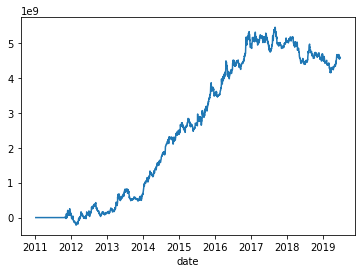

                tsmom-macdnma-commod_mkts-28-120-5-0.2
sharp_ratio_1y                            3.550728e-01
sharp_ratio_2y                           -3.578064e-01
sharp_ratio_3y                            1.734569e-01
sharp_ratio_4y                            6.762786e-01
sharp_ratio_5y                            8.782187e-01
sharp_ratio_6y                            9.758497e-01
sharp_ratio_8y                            9.472899e-01
std_pnl_1y                                3.383845e+07
std_pnl_2y                                3.830723e+07
std_pnl_3y                                4.242403e+07
std_pnl_4y                                4.614409e+07
std_pnl_5y                                4.397386e+07
std_pnl_6y                                4.199384e+07
std_pnl_8y                                3.942413e+07


<ipython-input-7-ae21987a4c76>:202: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  tdf['date'] = adf['date']


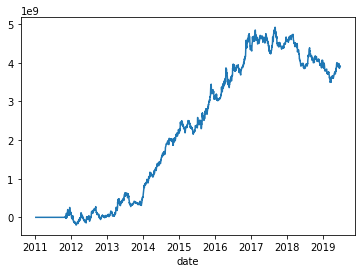

                tsmom-macdnma-commod_mkts-28-120-5-0.2
sharp_ratio_1y                            1.080214e-01
sharp_ratio_2y                           -5.295789e-01
sharp_ratio_3y                            1.253019e-01
sharp_ratio_4y                            5.752303e-01
sharp_ratio_5y                            7.677089e-01
sharp_ratio_6y                            8.862040e-01
sharp_ratio_8y                            8.484456e-01
std_pnl_1y                                3.262370e+07
std_pnl_2y                                3.683537e+07
std_pnl_3y                                4.081846e+07
std_pnl_4y                                4.427751e+07
std_pnl_5y                                4.194160e+07
std_pnl_6y                                4.007813e+07
std_pnl_8y                                3.751685e+07


<ipython-input-7-ae21987a4c76>:202: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  tdf['date'] = adf['date']


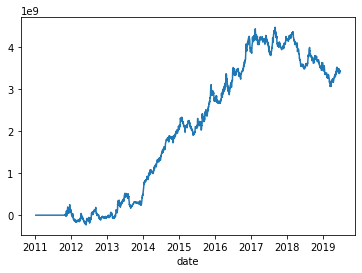

                tsmom-macdnma-commod_mkts-28-120-5-0.2
sharp_ratio_1y                           -1.178099e-01
sharp_ratio_2y                           -5.967775e-01
sharp_ratio_3y                            1.239047e-01
sharp_ratio_4y                            5.151339e-01
sharp_ratio_5y                            6.755271e-01
sharp_ratio_6y                            8.263027e-01
sharp_ratio_8y                            7.811818e-01
std_pnl_1y                                3.161349e+07
std_pnl_2y                                3.557753e+07
std_pnl_3y                                3.892136e+07
std_pnl_4y                                4.219193e+07
std_pnl_5y                                3.988606e+07
std_pnl_6y                                3.810208e+07
std_pnl_8y                                3.565308e+07


<ipython-input-7-ae21987a4c76>:202: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  tdf['date'] = adf['date']


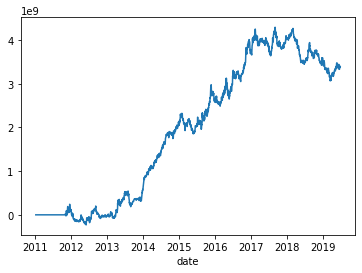

                tsmom-macdnma-commod_mkts-28-120-5-0.2
sharp_ratio_1y                           -1.285490e-01
sharp_ratio_2y                           -4.873329e-01
sharp_ratio_3y                            2.336293e-01
sharp_ratio_4y                            5.485829e-01
sharp_ratio_5y                            6.785674e-01
sharp_ratio_6y                            8.480357e-01
sharp_ratio_8y                            8.068638e-01
std_pnl_1y                                3.095482e+07
std_pnl_2y                                3.459344e+07
std_pnl_3y                                3.739621e+07
std_pnl_4y                                4.049540e+07
std_pnl_5y                                3.835943e+07
std_pnl_6y                                3.659288e+07
std_pnl_8y                                3.425284e+07


<ipython-input-7-ae21987a4c76>:202: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  tdf['date'] = adf['date']


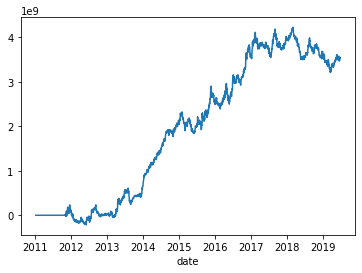

                tsmom-macdnma-commod_mkts-28-120-5-0.2
sharp_ratio_1y                            5.483162e-02
sharp_ratio_2y                           -2.534406e-01
sharp_ratio_3y                            4.203632e-01
sharp_ratio_4y                            6.384532e-01
sharp_ratio_5y                            7.320036e-01
sharp_ratio_6y                            9.033620e-01
sharp_ratio_8y                            8.645511e-01
std_pnl_1y                                3.048786e+07
std_pnl_2y                                3.367820e+07
std_pnl_3y                                3.614451e+07
std_pnl_4y                                3.921121e+07
std_pnl_5y                                3.726739e+07
std_pnl_6y                                3.549142e+07
std_pnl_8y                                3.325005e+07


<ipython-input-7-ae21987a4c76>:202: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  tdf['date'] = adf['date']


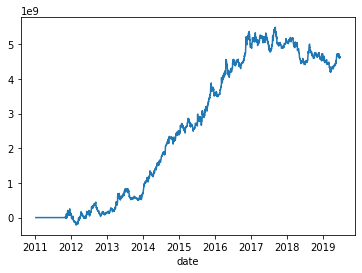

                tsmom-macdnma-commod_mkts-32-120-5-0.2
sharp_ratio_1y                            3.957527e-01
sharp_ratio_2y                           -3.397565e-01
sharp_ratio_3y                            1.686308e-01
sharp_ratio_4y                            6.865709e-01
sharp_ratio_5y                            8.853537e-01
sharp_ratio_6y                            9.820234e-01
sharp_ratio_8y                            9.528016e-01
std_pnl_1y                                3.409767e+07
std_pnl_2y                                3.861934e+07
std_pnl_3y                                4.262609e+07
std_pnl_4y                                4.636567e+07
std_pnl_5y                                4.422578e+07
std_pnl_6y                                4.221863e+07
std_pnl_8y                                3.968010e+07


<ipython-input-7-ae21987a4c76>:202: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  tdf['date'] = adf['date']


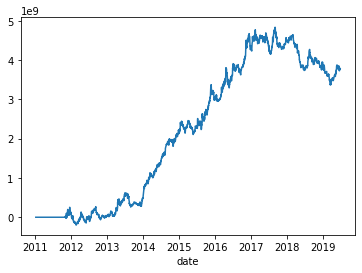

                tsmom-macdnma-commod_mkts-32-120-5-0.2
sharp_ratio_1y                            7.294081e-02
sharp_ratio_2y                           -5.861388e-01
sharp_ratio_3y                            8.766912e-02
sharp_ratio_4y                            5.490646e-01
sharp_ratio_5y                            7.467585e-01
sharp_ratio_6y                            8.582880e-01
sharp_ratio_8y                            8.232385e-01
std_pnl_1y                                3.260725e+07
std_pnl_2y                                3.687202e+07
std_pnl_3y                                4.073626e+07
std_pnl_4y                                4.412065e+07
std_pnl_5y                                4.179880e+07
std_pnl_6y                                3.994240e+07
std_pnl_8y                                3.739589e+07


<ipython-input-7-ae21987a4c76>:202: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  tdf['date'] = adf['date']


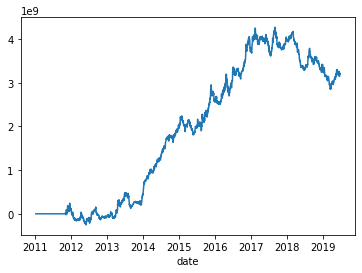

                tsmom-macdnma-commod_mkts-32-120-5-0.2
sharp_ratio_1y                           -1.792611e-01
sharp_ratio_2y                           -6.533186e-01
sharp_ratio_3y                            8.947403e-02
sharp_ratio_4y                            4.800160e-01
sharp_ratio_5y                            6.402985e-01
sharp_ratio_6y                            7.869862e-01
sharp_ratio_8y                            7.438321e-01
std_pnl_1y                                3.138009e+07
std_pnl_2y                                3.535266e+07
std_pnl_3y                                3.831379e+07
std_pnl_4y                                4.146991e+07
std_pnl_5y                                3.920787e+07
std_pnl_6y                                3.745485e+07
std_pnl_8y                                3.506034e+07


<ipython-input-7-ae21987a4c76>:202: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  tdf['date'] = adf['date']


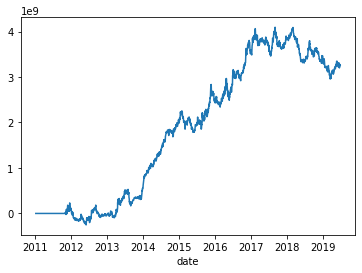

                tsmom-macdnma-commod_mkts-32-120-5-0.2
sharp_ratio_1y                           -1.152617e-01
sharp_ratio_2y                           -4.636866e-01
sharp_ratio_3y                            2.539701e-01
sharp_ratio_4y                            5.446164e-01
sharp_ratio_5y                            6.678683e-01
sharp_ratio_6y                            8.329025e-01
sharp_ratio_8y                            7.938691e-01
std_pnl_1y                                3.062697e+07
std_pnl_2y                                3.416801e+07
std_pnl_3y                                3.651162e+07
std_pnl_4y                                3.947575e+07
std_pnl_5y                                3.745352e+07
std_pnl_6y                                3.571738e+07
std_pnl_8y                                3.344284e+07


<ipython-input-7-ae21987a4c76>:202: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  tdf['date'] = adf['date']


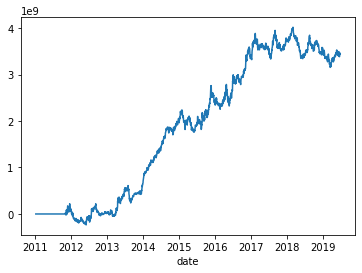

                tsmom-macdnma-commod_mkts-32-120-5-0.2
sharp_ratio_1y                            1.606952e-01
sharp_ratio_2y                           -1.431462e-01
sharp_ratio_3y                            4.894023e-01
sharp_ratio_4y                            6.627434e-01
sharp_ratio_5y                            7.417202e-01
sharp_ratio_6y                            9.060191e-01
sharp_ratio_8y                            8.683485e-01
std_pnl_1y                                3.006527e+07
std_pnl_2y                                3.301129e+07
std_pnl_3y                                3.503855e+07
std_pnl_4y                                3.802993e+07
std_pnl_5y                                3.626330e+07
std_pnl_6y                                3.452692e+07
std_pnl_8y                                3.235145e+07


<ipython-input-7-ae21987a4c76>:202: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  tdf['date'] = adf['date']


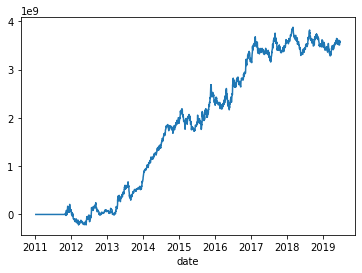

                tsmom-macdnma-commod_mkts-32-120-5-0.2
sharp_ratio_1y                            4.764489e-01
sharp_ratio_2y                            1.960981e-01
sharp_ratio_3y                            7.041237e-01
sharp_ratio_4y                            7.690108e-01
sharp_ratio_5y                            8.078828e-01
sharp_ratio_6y                            9.605364e-01
sharp_ratio_8y                            9.241603e-01
std_pnl_1y                                2.936975e+07
std_pnl_2y                                3.173546e+07
std_pnl_3y                                3.362440e+07
std_pnl_4y                                3.685823e+07
std_pnl_5y                                3.533519e+07
std_pnl_6y                                3.363497e+07
std_pnl_8y                                3.155029e+07


<ipython-input-7-ae21987a4c76>:202: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  tdf['date'] = adf['date']


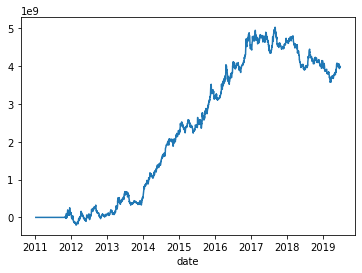

                tsmom-macdnma-commod_mkts-36-120-5-0.2
sharp_ratio_1y                            1.534653e-01
sharp_ratio_2y                           -5.619210e-01
sharp_ratio_3y                            8.131802e-02
sharp_ratio_4y                            5.716035e-01
sharp_ratio_5y                            7.834501e-01
sharp_ratio_6y                            8.817731e-01
sharp_ratio_8y                            8.517252e-01
std_pnl_1y                                3.307608e+07
std_pnl_2y                                3.744892e+07
std_pnl_3y                                4.144004e+07
std_pnl_4y                                4.487344e+07
std_pnl_5y                                4.260924e+07
std_pnl_6y                                4.070338e+07
std_pnl_8y                                3.814926e+07


<ipython-input-7-ae21987a4c76>:202: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  tdf['date'] = adf['date']


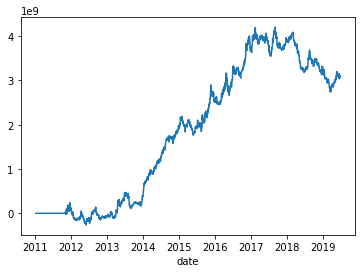

                tsmom-macdnma-commod_mkts-36-120-5-0.2
sharp_ratio_1y                           -1.942635e-01
sharp_ratio_2y                           -7.066467e-01
sharp_ratio_3y                            4.596481e-02
sharp_ratio_4y                            4.546650e-01
sharp_ratio_5y                            6.232205e-01
sharp_ratio_6y                            7.581673e-01
sharp_ratio_8y                            7.173449e-01
std_pnl_1y                                3.144476e+07
std_pnl_2y                                3.550435e+07
std_pnl_3y                                3.838631e+07
std_pnl_4y                                4.152975e+07
std_pnl_5y                                3.925601e+07
std_pnl_6y                                3.750860e+07
std_pnl_8y                                3.511749e+07


<ipython-input-7-ae21987a4c76>:202: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  tdf['date'] = adf['date']


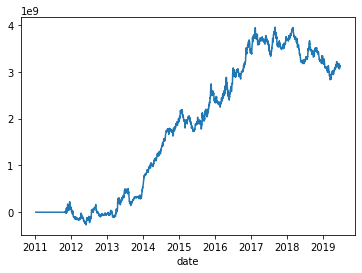

                tsmom-macdnma-commod_mkts-36-120-5-0.2
sharp_ratio_1y                           -1.348770e-01
sharp_ratio_2y                           -4.950845e-01
sharp_ratio_3y                            2.246600e-01
sharp_ratio_4y                            5.185772e-01
sharp_ratio_5y                            6.452640e-01
sharp_ratio_6y                            8.036513e-01
sharp_ratio_8y                            7.669517e-01
std_pnl_1y                                3.049722e+07
std_pnl_2y                                3.405601e+07
std_pnl_3y                                3.615317e+07
std_pnl_4y                                3.904787e+07
std_pnl_5y                                3.706963e+07
std_pnl_6y                                3.535287e+07
std_pnl_8y                                3.309851e+07


<ipython-input-7-ae21987a4c76>:202: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  tdf['date'] = adf['date']


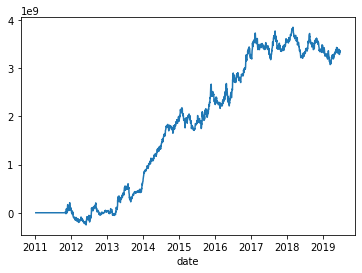

                tsmom-macdnma-commod_mkts-36-120-5-0.2
sharp_ratio_1y                            2.072664e-01
sharp_ratio_2y                           -1.008597e-01
sharp_ratio_3y                            5.014742e-01
sharp_ratio_4y                            6.587204e-01
sharp_ratio_5y                            7.339680e-01
sharp_ratio_6y                            8.932288e-01
sharp_ratio_8y                            8.574745e-01
std_pnl_1y                                2.977852e+07
std_pnl_2y                                3.263136e+07
std_pnl_3y                                3.440723e+07
std_pnl_4y                                3.734295e+07
std_pnl_5y                                3.569188e+07
std_pnl_6y                                3.398990e+07
std_pnl_8y                                3.183699e+07


<ipython-input-7-ae21987a4c76>:202: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  tdf['date'] = adf['date']


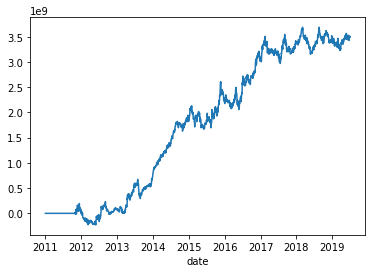

                tsmom-macdnma-commod_mkts-36-120-5-0.2
sharp_ratio_1y                            5.818784e-01
sharp_ratio_2y                            3.049738e-01
sharp_ratio_3y                            7.444849e-01
sharp_ratio_4y                            7.774820e-01
sharp_ratio_5y                            8.094307e-01
sharp_ratio_6y                            9.544676e-01
sharp_ratio_8y                            9.205845e-01
std_pnl_1y                                2.877798e+07
std_pnl_2y                                3.104923e+07
std_pnl_3y                                3.273705e+07
std_pnl_4y                                3.602592e+07
std_pnl_5y                                3.467067e+07
std_pnl_6y                                3.303030e+07
std_pnl_8y                                3.097948e+07


<ipython-input-7-ae21987a4c76>:202: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  tdf['date'] = adf['date']


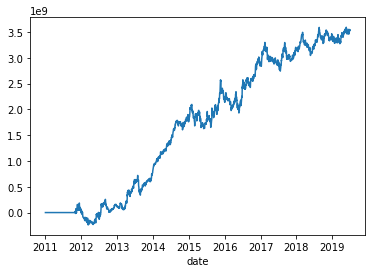

                tsmom-macdnma-commod_mkts-36-120-5-0.2
sharp_ratio_1y                            8.712429e-01
sharp_ratio_2y                            6.481619e-01
sharp_ratio_3y                            9.081905e-01
sharp_ratio_4y                            8.458276e-01
sharp_ratio_5y                            8.526711e-01
sharp_ratio_6y                            9.754276e-01
sharp_ratio_8y                            9.506781e-01
std_pnl_1y                                2.750093e+07
std_pnl_2y                                2.963367e+07
std_pnl_3y                                3.115718e+07
std_pnl_4y                                3.497009e+07
std_pnl_5y                                3.384893e+07
std_pnl_6y                                3.230320e+07
std_pnl_8y                                3.035914e+07


<ipython-input-7-ae21987a4c76>:202: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  tdf['date'] = adf['date']


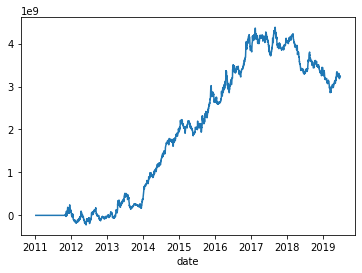

                tsmom-macdnma-commod_mkts-40-120-5-0.2
sharp_ratio_1y                           -1.192249e-01
sharp_ratio_2y                           -7.205016e-01
sharp_ratio_3y                            2.016153e-02
sharp_ratio_4y                            4.643771e-01
sharp_ratio_5y                            6.512256e-01
sharp_ratio_6y                            7.667582e-01
sharp_ratio_8y                            7.308728e-01
std_pnl_1y                                3.193530e+07
std_pnl_2y                                3.617039e+07
std_pnl_3y                                3.941599e+07
std_pnl_4y                                4.262806e+07
std_pnl_5y                                4.030791e+07
std_pnl_6y                                3.852443e+07
std_pnl_8y                                3.606417e+07


<ipython-input-7-ae21987a4c76>:202: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  tdf['date'] = adf['date']


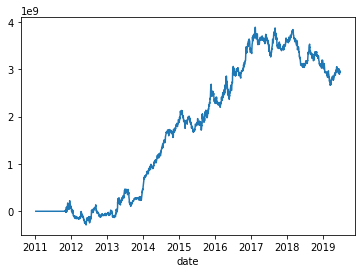

                tsmom-macdnma-commod_mkts-40-120-5-0.2
sharp_ratio_1y                           -2.064898e-01
sharp_ratio_2y                           -6.030663e-01
sharp_ratio_3y                            1.372206e-01
sharp_ratio_4y                            4.674426e-01
sharp_ratio_5y                            6.086208e-01
sharp_ratio_6y                            7.566089e-01
sharp_ratio_8y                            7.217676e-01
std_pnl_1y                                3.060289e+07
std_pnl_2y                                3.432292e+07
std_pnl_3y                                3.638359e+07
std_pnl_4y                                3.928746e+07
std_pnl_5y                                3.725711e+07
std_pnl_6y                                3.554439e+07
std_pnl_8y                                3.327459e+07


<ipython-input-7-ae21987a4c76>:202: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  tdf['date'] = adf['date']


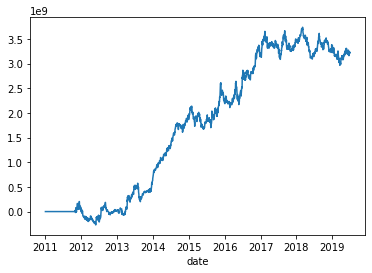

                tsmom-macdnma-commod_mkts-40-120-5-0.2
sharp_ratio_1y                            1.658160e-01
sharp_ratio_2y                           -1.554429e-01
sharp_ratio_3y                            4.499946e-01
sharp_ratio_4y                            6.225070e-01
sharp_ratio_5y                            7.061223e-01
sharp_ratio_6y                            8.627226e-01
sharp_ratio_8y                            8.289824e-01
std_pnl_1y                                2.970718e+07
std_pnl_2y                                3.264734e+07
std_pnl_3y                                3.429159e+07
std_pnl_4y                                3.714686e+07
std_pnl_5y                                3.552307e+07
std_pnl_6y                                3.384123e+07
std_pnl_8y                                3.167868e+07


<ipython-input-7-ae21987a4c76>:202: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  tdf['date'] = adf['date']


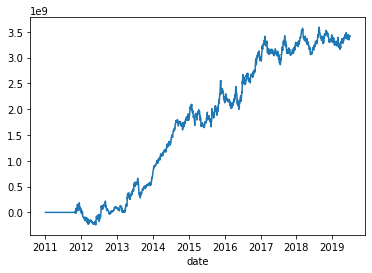

                tsmom-macdnma-commod_mkts-40-120-5-0.2
sharp_ratio_1y                            6.004833e-01
sharp_ratio_2y                            3.195250e-01
sharp_ratio_3y                            7.333213e-01
sharp_ratio_4y                            7.602526e-01
sharp_ratio_5y                            7.947923e-01
sharp_ratio_6y                            9.383897e-01
sharp_ratio_8y                            9.061194e-01
std_pnl_1y                                2.844451e+07
std_pnl_2y                                3.076224e+07
std_pnl_3y                                3.236116e+07
std_pnl_4y                                3.561442e+07
std_pnl_5y                                3.435399e+07
std_pnl_6y                                3.274963e+07
std_pnl_8y                                3.069829e+07


<ipython-input-7-ae21987a4c76>:202: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  tdf['date'] = adf['date']


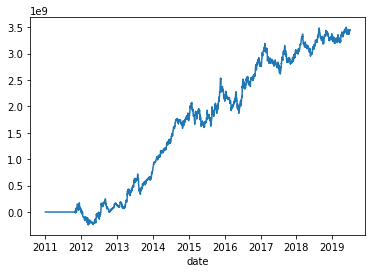

                tsmom-macdnma-commod_mkts-40-120-5-0.2
sharp_ratio_1y                            8.794428e-01
sharp_ratio_2y                            6.904233e-01
sharp_ratio_3y                            9.017343e-01
sharp_ratio_4y                            8.238217e-01
sharp_ratio_5y                            8.334091e-01
sharp_ratio_6y                            9.550060e-01
sharp_ratio_8y                            9.353467e-01
std_pnl_1y                                2.689638e+07
std_pnl_2y                                2.920246e+07
std_pnl_3y                                3.061809e+07
std_pnl_4y                                3.445441e+07
std_pnl_5y                                3.346798e+07
std_pnl_6y                                3.197965e+07
std_pnl_8y                                3.005048e+07


<ipython-input-7-ae21987a4c76>:202: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  tdf['date'] = adf['date']


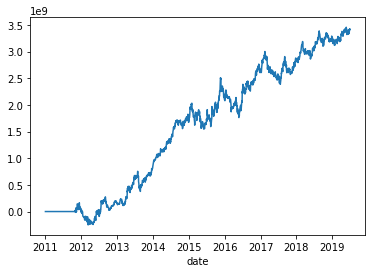

                tsmom-macdnma-commod_mkts-40-120-5-0.2
sharp_ratio_1y                            1.026427e+00
sharp_ratio_2y                            9.750840e-01
sharp_ratio_3y                            1.006006e+00
sharp_ratio_4y                            8.554218e-01
sharp_ratio_5y                            8.436804e-01
sharp_ratio_6y                            9.454498e-01
sharp_ratio_8y                            9.394898e-01
std_pnl_1y                                2.572078e+07
std_pnl_2y                                2.835176e+07
std_pnl_3y                                2.951740e+07
std_pnl_4y                                3.382482e+07
std_pnl_5y                                3.296825e+07
std_pnl_6y                                3.156063e+07
std_pnl_8y                                2.970953e+07
         1.5       2.0       2.5       3.0       3.5       4.0
2  -0.008184  0.040796  0.095328  0.147190  0.195301  0.240324
4   0.253919  0.354830  0.443043  0.516306  0.574

In [21]:
res = {}
stats_list = []
cum_list = []
sratio_years = [int(ten[:-1]) for ten in pnl_tenors]
reverse_list = ['lrkurt']

metal_mixed_mkts = ['rb', 'hc', 'i', 'j', 'jm', 'ru', 'FG', 'ZC', 'cu', 'al', 'zn', 'ni']
petro_mixed_mkts = ['l', 'pp', 'v', 'TA', 'MA', 'bu', 'sc']
ags_mixed_mkts = ['m', 'RM', 'y', 'p', 'OI', 'a', 'c', 'cs', 'CF', 'SR', 'jd']
commod_mkts = ['rb', 'hc', 'i', 'j', 'jm', 'ru', 'FG', 'ZC', 'cu', 'al', 'zn', 'pb', 'sn', \
               'l', 'pp', 'v', 'TA', 'sc', 'm', 'RM', 'y', 'p', 'OI', 'a', 'c', 'CF', 'jd', \
               'AP', 'SM']
# 'SM', "SF", 'au', 'ag', 'fu', 'eg', 'b', 'AP']

product_list = commod_mkts # metal_mixed_mkts # +  petro_mixed_mkts #  
# # ind_metal_mkts #commod_all_mkts #  ferrous_products_mkts #+ ferrous_mixed_mkts + base_metal_mkts
product_name = 'commod_mkts'

sim_name = 'tsmom'
run_mode = 'macdnma'

start_date = datetime.date(2011,1,1)
end_date = datetime.date(2019,6,30)
quantile = 0.2
cost_ratio = 0.5
pos_std = 1
std_win = 20
win = 60
ma_win = 120
rebal = 5
params = [0.0, 0.0]

exec_field = 'open'
save_loc = "C:\\dev\\data\\selected_%s_" % ('_'.join([sim_name, run_mode, product_name, str(quantile), str(end_date)]))

#save_loc = "C:\\dev\\data\\combined_carry_" + product_name + "_" + str(end_date) + '_'

#curve_list = ['linear', 'semilinear', 'reverting', 'absorbing', 'sigmoid', 'band']
crv_param = 2.0

index_list = [2] + [i for i in range(4, 44, 4)] # [i for i in range(10, 330, 10)]  # [1, 2, 3, 4, 5, 10, 15, 20, 25, 30] # [1, 3, 5, 7, 10, 15, 20] # + range(10, 250, 10) # 
column_list =  [1.5, 2, 2.5, 3, 3.5, 4] #   curve_list #   [1, 2, 3, 4, 5, 10, 15, 20] # range(10, 130, 10) # # [60, 80, 100, 120, 140, 160] #[i * 0.01 for i in range(0, 32, 4)] #

sratio = {}
run_sratio = True

pos_sum = pd.DataFrame()
pos_list = []
scenarios = list(itertools.product(index_list, column_list))

if 'ts' in sim_name:
    sim_func = run_ts_test
elif 'xs' in sim_name:
    sim_func = run_xs_test
if run_sratio:
    for yr in sratio_years:
        sratio[yr] = pd.DataFrame(0, index = index_list, columns = column_list)

port_pnl = pd.Series()
#pos_map = (None, {}, '')
#pos_map = (misc.sign, {}, 'sign')
pos_map = (dh.response_curve, {'param': crv_param, "response": 'reverting'}, 'reverting')

for scen in scenarios:
    scen_x = scen[0]
    scen_y = scen[1]
    if run_mode in ['ryield']:
        win = 1
        ma_win = 1
        rebal = scen_x
        pos_map = (dh.response_curve, {'param': crv_param, "response": scen_y}, scen_y)
        if sim_name == 'xscarry':
            quantile = scen_x * 0.1
    elif run_mode in ['basmom', 'mom', 'clbrk', 'hlbrk']:
        win = scen_x
        ma_win = 1
        rebal = scen_y
    elif run_mode in ['mixmom']:
        win = scen_x
        ma_win = 1
        rebal = scen_y
    elif ('ts' in sim_name) and (run_mode in ['ryieldxma', 'ryieldsma', \
                                              'ryieldnma', 'ryieldnmb', 'ryieldzlv', \
                                              'lrskewsma', 'lrkurtsma', 'trdstrsma',\
                                              'upstdsma', 'volmfratiosma']):
        win = 1
        ma_win = scen_x
        rebal = scen_y
        #pos_map = (dh.response_curve, {'param': crv_param, "response": scen_y}, scen_y)
    elif ('xs' in sim_name) and (run_mode in ['ryieldxma', 'ryieldsma', \
                                              'ryieldnma', 'ryieldnmb', 'ryieldzlv', \
                                              'lrskewsma', 'lrkurtsma', 'trdstrsma',\
                                              'upstdsma', 'volmfratiosma']):
        win = 1
        ma_win = scen_x
        rebal = scen_y    
    elif run_mode in ['basmomxma', 'basmomsma', 'basmomnma', 'basmomnmb', 'basmomzlv', \
                      'momsma', 'momxma', 'momnma', 'momnmb', 'momzlv', 'macdnma']:
        win = scen_x
        ma_win = 120
        rebal = 5
        if run_mode in ['macdnma']:
            params = [scen_y, 80.0/win]
    else:
        print("unsupported run_mode")
        continue

    run_args = {}        
    run_args['run_name'] = run_name = '-'.join([sim_name, run_mode, product_name, str(win), str(ma_win), str(rebal), str(quantile)])
    run_args['cost_ratio'] = cost_ratio
    run_args['exec_field'] = exec_field
    run_args['product_list'] = product_list
    run_args['start_date'] = start_date
    run_args['end_date'] = end_date
    
    run_args['win'] = win
    run_args['ma_win'] = ma_win
    run_args['std_win'] = std_win
    run_args['prefix'] = save_loc        
    run_args['rebal_freq'] = rebal
    run_args['pos_std'] = pos_std
    run_args['params'] = params
    run_args['pos_map'] = pos_map
    run_args['run_mode'] = run_mode
    run_args['quantile'] = quantile
    res = sim_func(run_args)
    res['cum_pnl'].plot()
    plt.show()
    cum_list.append(res['cum_pnl'])
    stats_list.append(res['pnl_stats'])
    vdf = res['pnl_stats']
    vdf = vdf.loc[[idx for idx in vdf.index if ('sharp' in idx) or ('std' in idx)], :]
    print(vdf)
    if run_sratio:
        for yr in sratio_years:
            lbl = 'sharp_ratio_' + str(yr) + 'y'
            sratio[yr][scen_y].loc[scen_x] = res['pnl_stats'][run_name][lbl]

cum_df = pd.concat(cum_list, axis = 1)
cum_df.to_csv(save_loc + 'pnl.csv')
stats_df = pd.concat(stats_list, axis = 1)
stats_df.T.to_csv(save_loc + 'stats.csv')

if run_sratio:
    for yr in sratio_years:
        print(sratio[yr])


In [22]:
save_xl = True

if run_sratio and save_xl:
    xlfile = save_loc + "sratio_heatmap_param.xlsx"
    writer = pd.ExcelWriter(xlfile)
    for yr in sratio_years:
        lbl = 'sharp_ratio_' + str(yr) + 'y'
        sratio[yr].to_excel(writer, lbl, startcol= 0, startrow=1)
    writer.save()    